# Introduction

Why do we do Outlier Detection in Signal Processing?

- **Noise Reduction:** Signals in real-world applications often contain noise, and outliers can result from this noise. Detecting and removing outliers helps reduce the impact of noise, providing a cleaner and more accurate representation of the underlying signal.

- **Data Quality Improvement:** Outliers can distort the overall characteristics of a signal, affecting the quality of the data. Identifying and eliminating outliers leads to improved accuracy and reliability in subsequent analyses or applications.

- **Fault Detection and Diagnosis:** Outliers may indicate faults or abnormal conditions. Detecting outliers helps engineers and analysts identify potential issues in a system or process, especially in industrial monitoring where early fault detection is critical.

- **Anomaly Detection:** Outlier detection is closely related to anomaly detection. Anomalies in a signal may represent events or conditions that deviate from the expected behavior, crucial for applications such as intrusion detection in cybersecurity.

- **Robustness of Algorithms:** Outliers can violate algorithmic assumptions and lead to suboptimal performance. Detecting and handling outliers appropriately makes algorithms more robust and resistant to extreme values.

- **Improved Signal Interpretation:** Outlier detection aids in better understanding and interpretation of signals. Removing outliers allows researchers and practitioners to focus on the underlying patterns and trends, leading to more accurate conclusions and informed decision-making.

- **Statistical Analysis:** Outliers can significantly impact statistical analyses. Identifying and handling outliers is essential for obtaining meaningful statistical results and ensuring that the analysis is not unduly influenced by extreme values.

In summary, outlier detection in signal processing plays a crucial role in enhancing the reliability, accuracy, and interpretability of signals, making it an essential step in various applications across different domains.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from sklearn.neighbors import LocalOutlierFactor  # pip install scikit-learn

# --------------------------------------------------------------
# Load data
# --------------------------------------------------------------
df = pd.read_pickle("../../data/interim/01_data_processed.pkl")

In [2]:
display(df.head())

acc_x     acc_y     acc_z  gyro_x  gyro_y  gyro_z  \
epoch (ms)                                                                      
2019-01-11 15:08:05.200  0.013500  0.977000 -0.071000 -1.8904  2.4392  0.9388   
2019-01-11 15:08:05.400 -0.001500  0.970500 -0.079500 -1.6826 -0.8904  2.1708   
2019-01-11 15:08:05.600  0.001333  0.971667 -0.064333  2.5608 -0.2560 -1.4146   
2019-01-11 15:08:05.800 -0.024000  0.957000 -0.073500  8.0610 -4.5244 -2.0730   
2019-01-11 15:08:06.000 -0.028000  0.957667 -0.115000  2.4390 -1.5486 -3.6098   

                        participant excercise intensity  ind  
epoch (ms)                                                    
2019-01-11 15:08:05.200           B     bench    heavy1   30  
2019-01-11 15:08:05.400           B     bench    heavy1   30  
2019-01-11 15:08:05.600           B     bench    heavy1   30  
2019-01-11 15:08:05.800           B     bench    heavy1   30  
2019-01-11 15:08:06.000           B     bench    heavy1   30

acc_y    AxesSubplot(0.08,0.07;0.87x0.81)
dtype: object

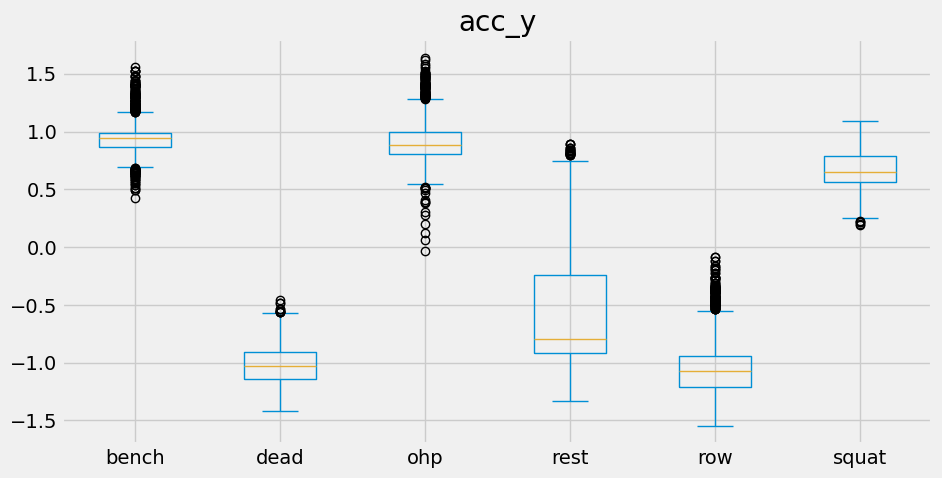

In [3]:
# --------------------------------------------------------------
# Plotting outliers
# --------------------------------------------------------------
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100

df[["acc_y", "excercise"]].plot(by = "excercise",
                                kind = "box",
                                figsize = (10, 5),
                                label = "excercise", )

gyro_y    Axes(0.08,0.07;0.87x0.81)
dtype: object

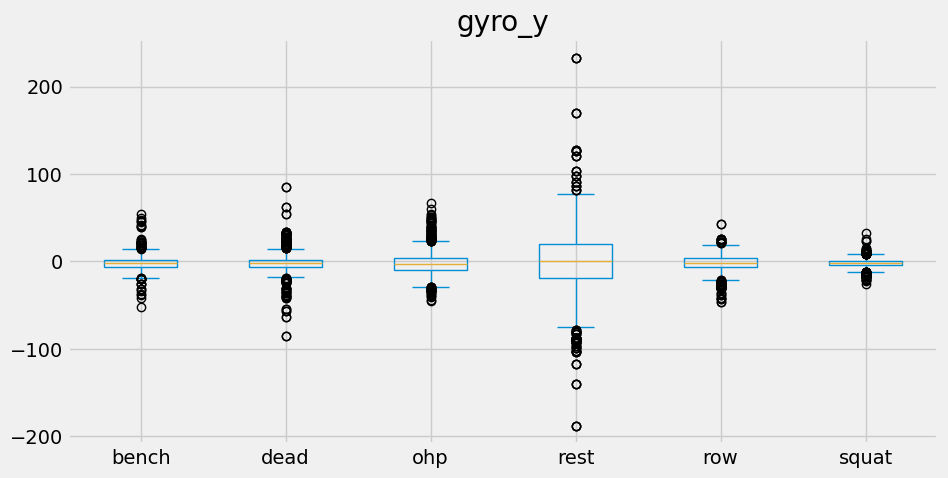

In [44]:
df[["gyro_y", "excercise"]].plot(by = "excercise",
                                kind = "box",
                                figsize = (10, 5),
                                label = "excercise", )

acc_x        Axes(0.08,0.07;0.255882x0.81)
acc_y    Axes(0.387059,0.07;0.255882x0.81)
acc_z    Axes(0.694118,0.07;0.255882x0.81)
dtype: object

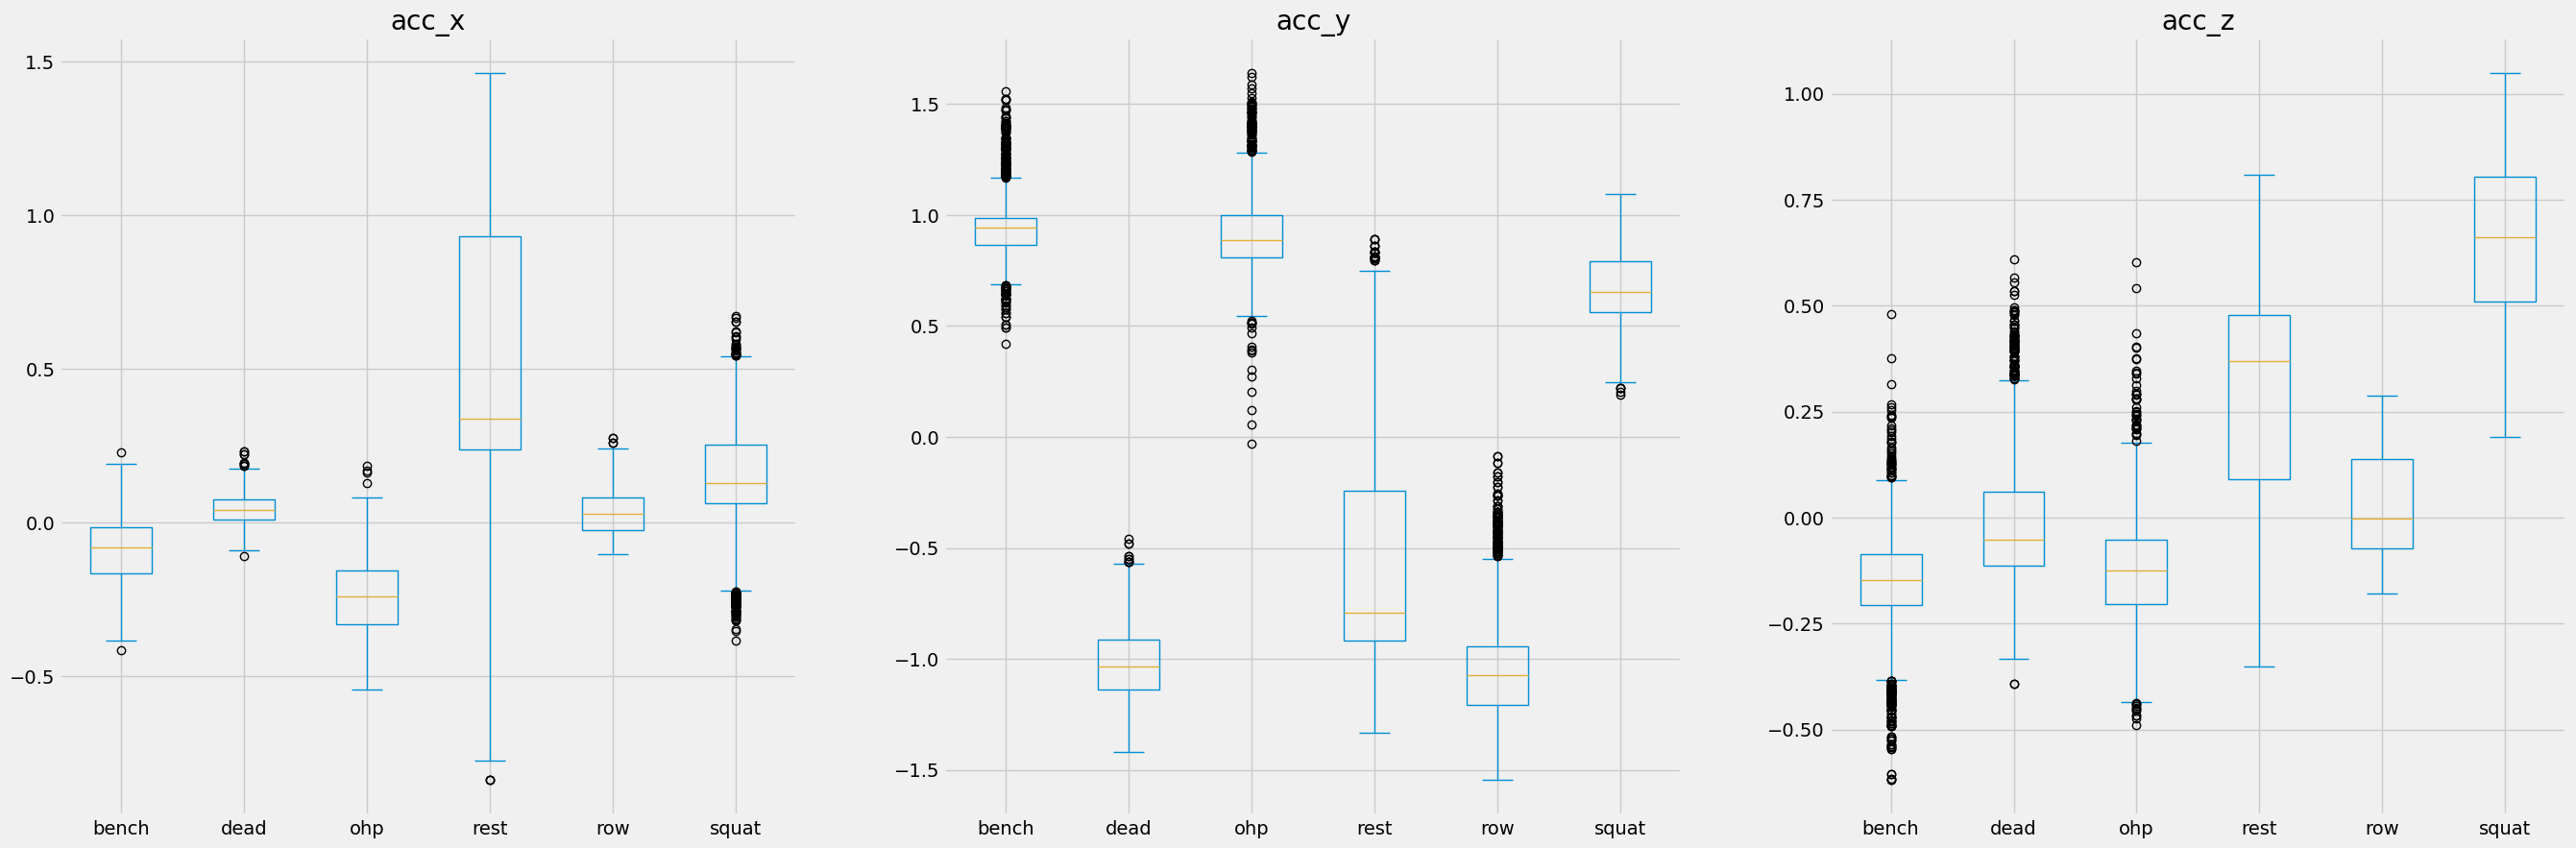

In [45]:
col_num = list(df.select_dtypes([np.number]).columns)
col_num.remove("ind")
# Plotting accelerometer data
df[col_num[:3] + ["excercise"]].plot(by = "excercise",
                                kind = "box",
                                figsize = (30, 10),
                                label = "excercise",
                                     layout = (1, 3))


gyro_x        Axes(0.08,0.07;0.255882x0.81)
gyro_y    Axes(0.387059,0.07;0.255882x0.81)
gyro_z    Axes(0.694118,0.07;0.255882x0.81)
dtype: object

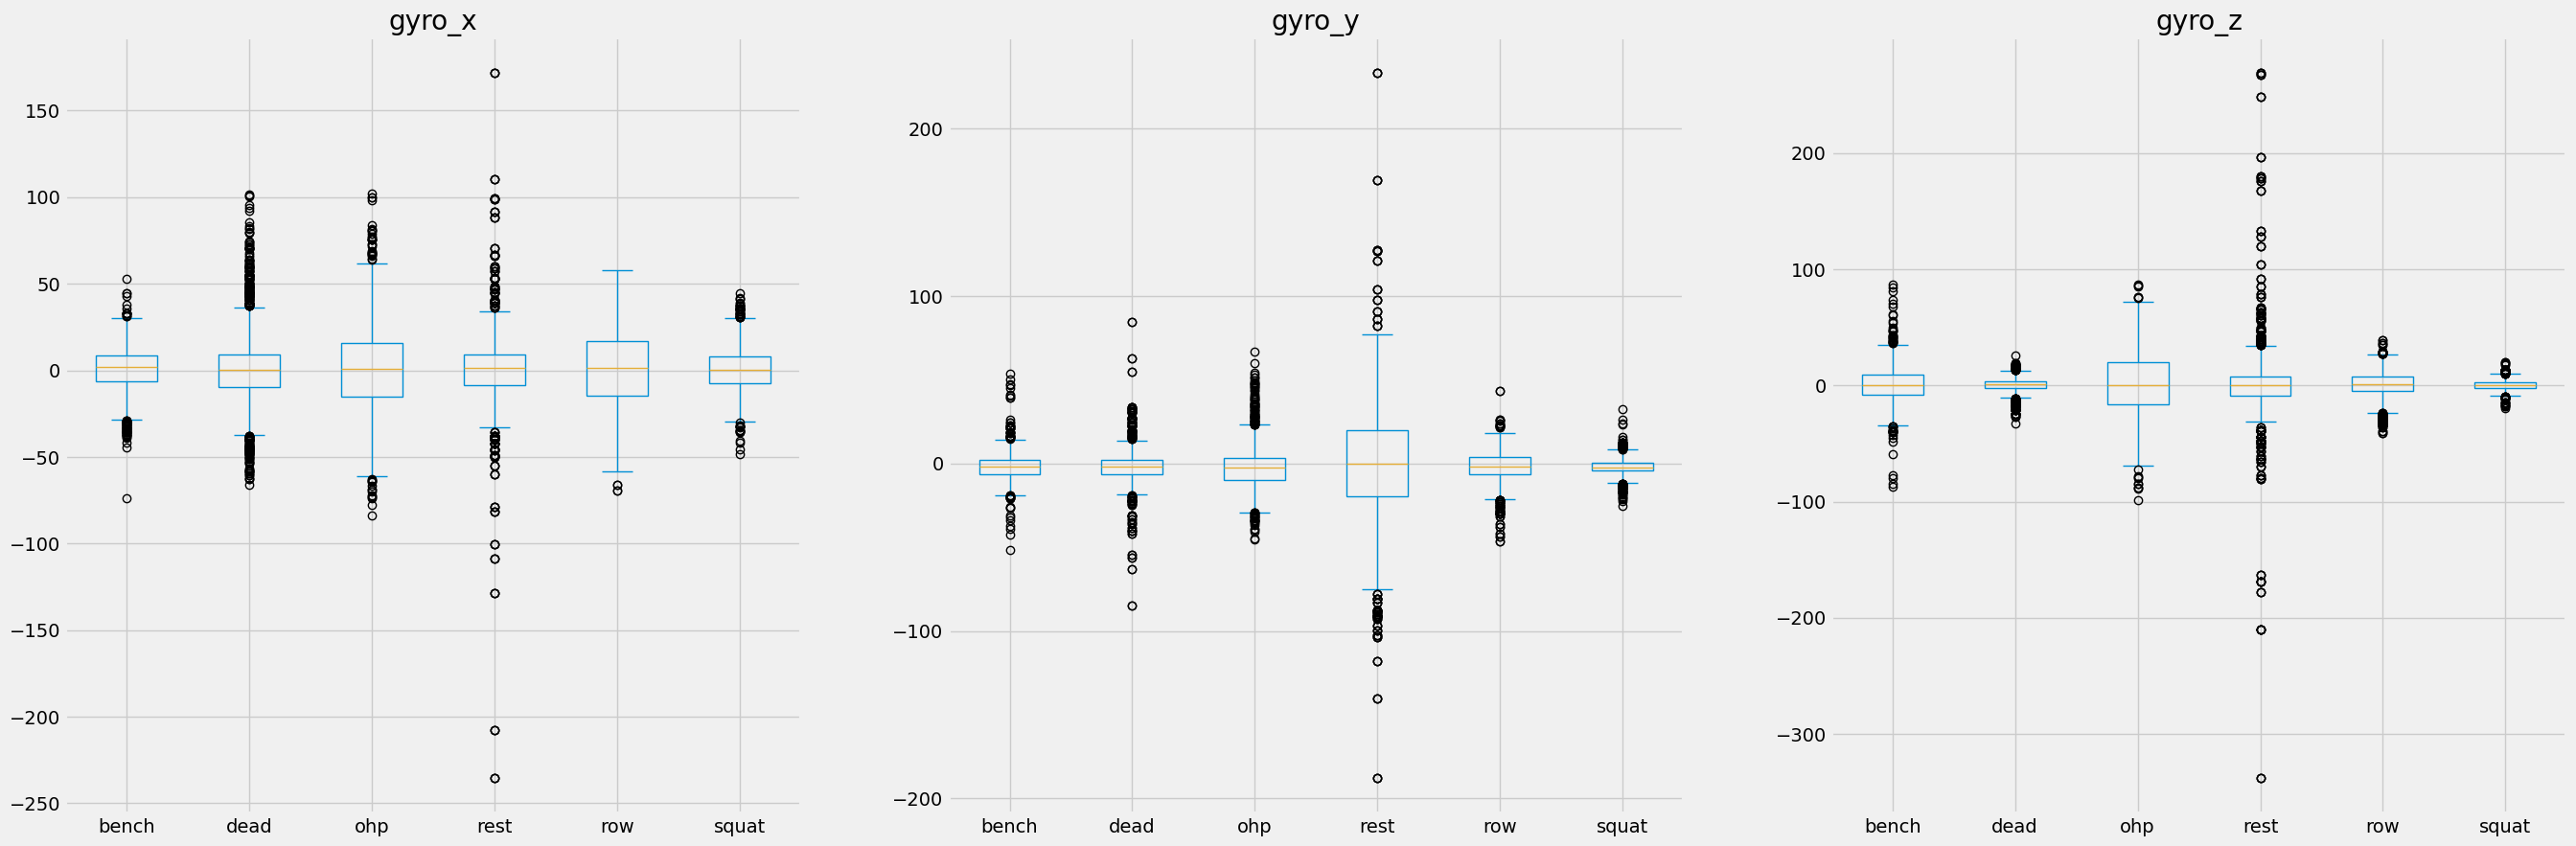

In [46]:
# Plotting gyroscope data
df[col_num[3:6] + ["excercise"]].plot(by = "excercise",
                                kind = "box",
                                figsize = (30, 10),
                                label = "excercise",
                                      layout = (1, 3))

In [47]:
# Plotting outliers in time
def plot_binary_outliers(dataset, col, outlier_col, reset_index):
    """ Plot outliers in case of a binary outlier score. Here, the col specifies the real data
    column and outlier_col the columns with a binary value (outlier or not).

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): Column that you want to plot
        outlier_col (string): Outlier column marked with true/false
        reset_index (bool): whether to reset the index for plotting
    """

    # Taken from: https://github.com/mhoogen/ML4QS/blob/master/Python3Code/util/VisualizeDataset.py

    dataset = dataset.dropna(axis=0, subset=[col, outlier_col])
    dataset[outlier_col] = dataset[outlier_col].astype("bool")

    if reset_index:
        dataset = dataset.reset_index()

    fig, ax = plt.subplots()

    plt.xlabel("samples")
    plt.ylabel("value")

    # Plot non outliers in default color
    ax.plot(
        dataset.index[~dataset[outlier_col]],
        dataset[col][~dataset[outlier_col]],
        "+",
    )
    # Plot data points that are outliers in red
    ax.plot(
        dataset.index[dataset[outlier_col]],
        dataset[col][dataset[outlier_col]],
        "r+",
    )

    plt.legend(
        ["outlier " + col, "no outlier " + col],
        loc="upper center",
        ncol=2,
        fancybox=True,
        shadow=True,
    )
    plt.show()

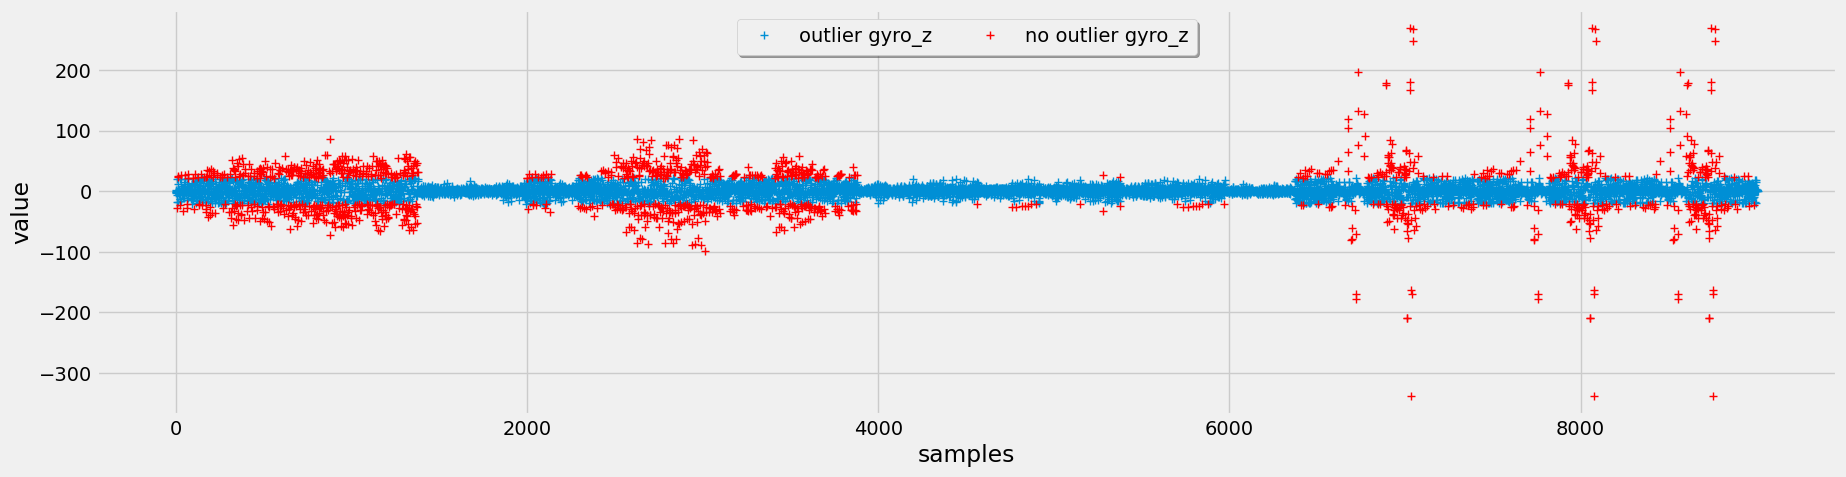

In [60]:
# --------------------------------------------------------------
# Interquartile range (distribution based)
# --------------------------------------------------------------

# Insert IQR function
def mark_outliers_iqr(df, col):
  df = df.copy()
  Q1 = np.percentile(df[col], 25, method='midpoint')
  Q3 = np.percentile(df[col], 75, method='midpoint')
  IQR = Q3 - Q1
  df[f"{col}_outlier"] = np.array((df[col] > Q3 + IQR * 1.5) | (df[col] < Q1 - IQR * 1.5))
  return df

# Plot a single column
col = "gyro_z"
df_distribution = mark_outliers_iqr(df, col)
plot_binary_outliers(df_distribution, col, f"{col}_outlier", True)



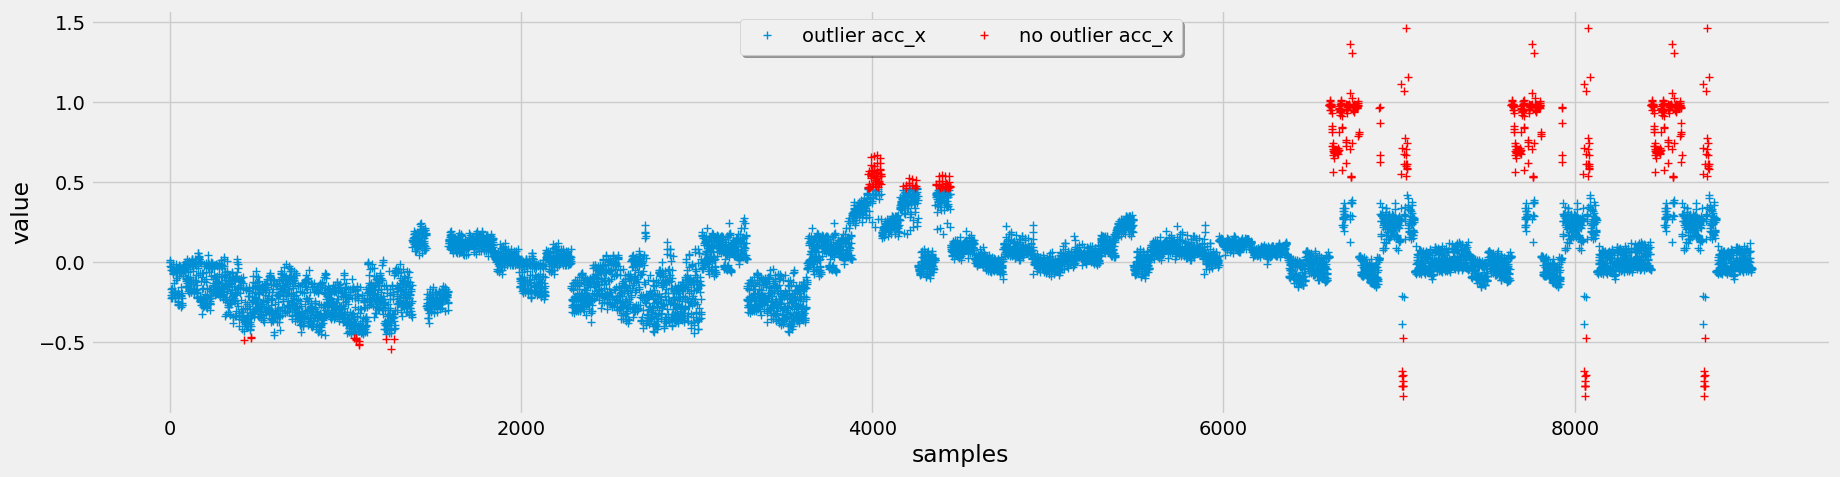

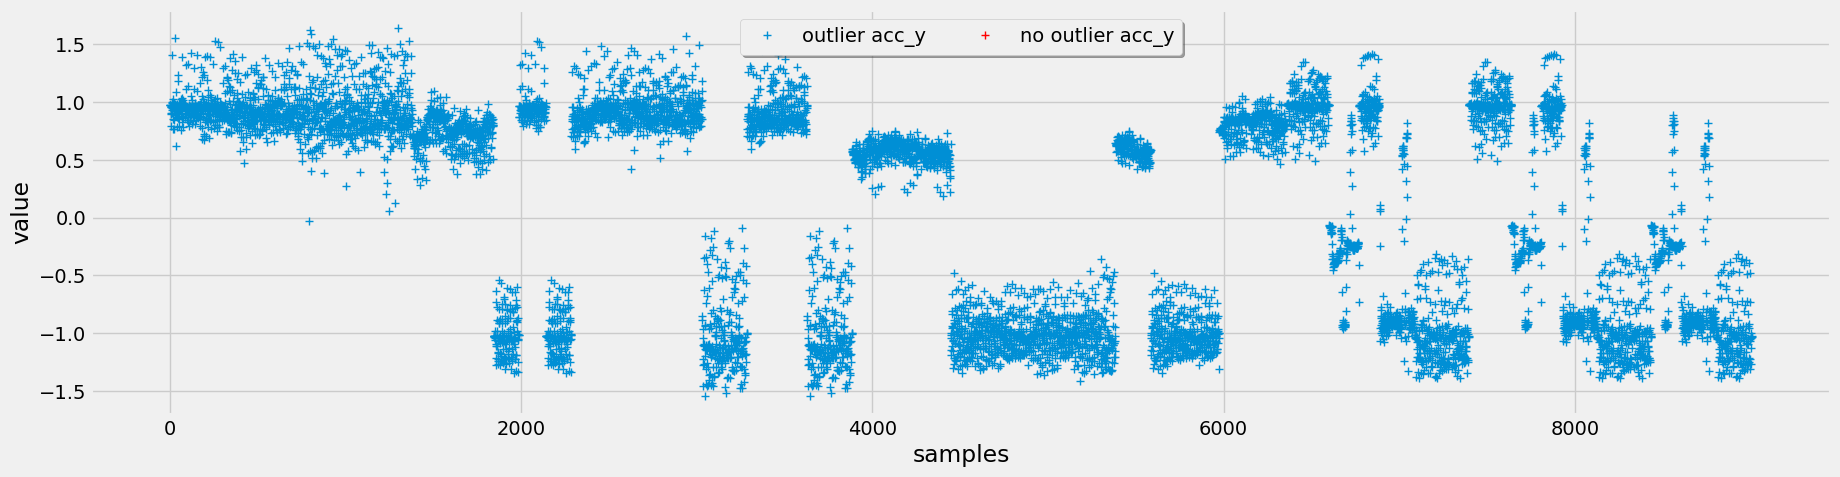

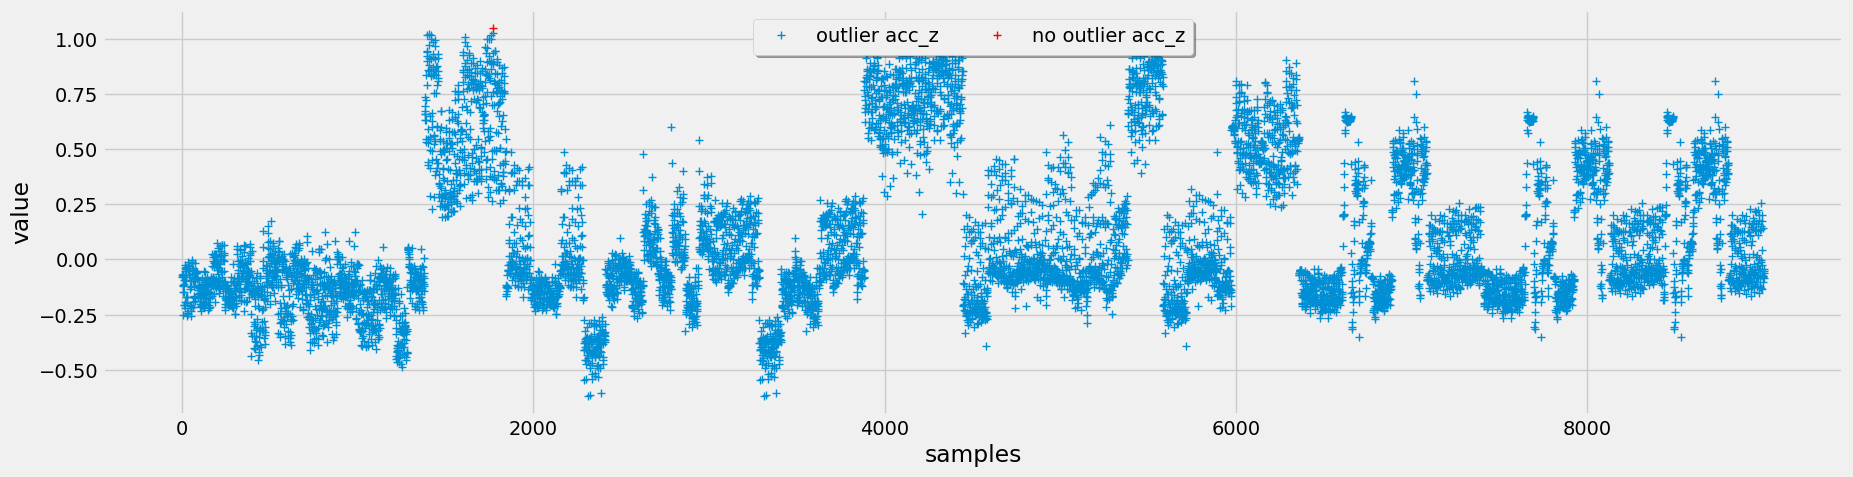

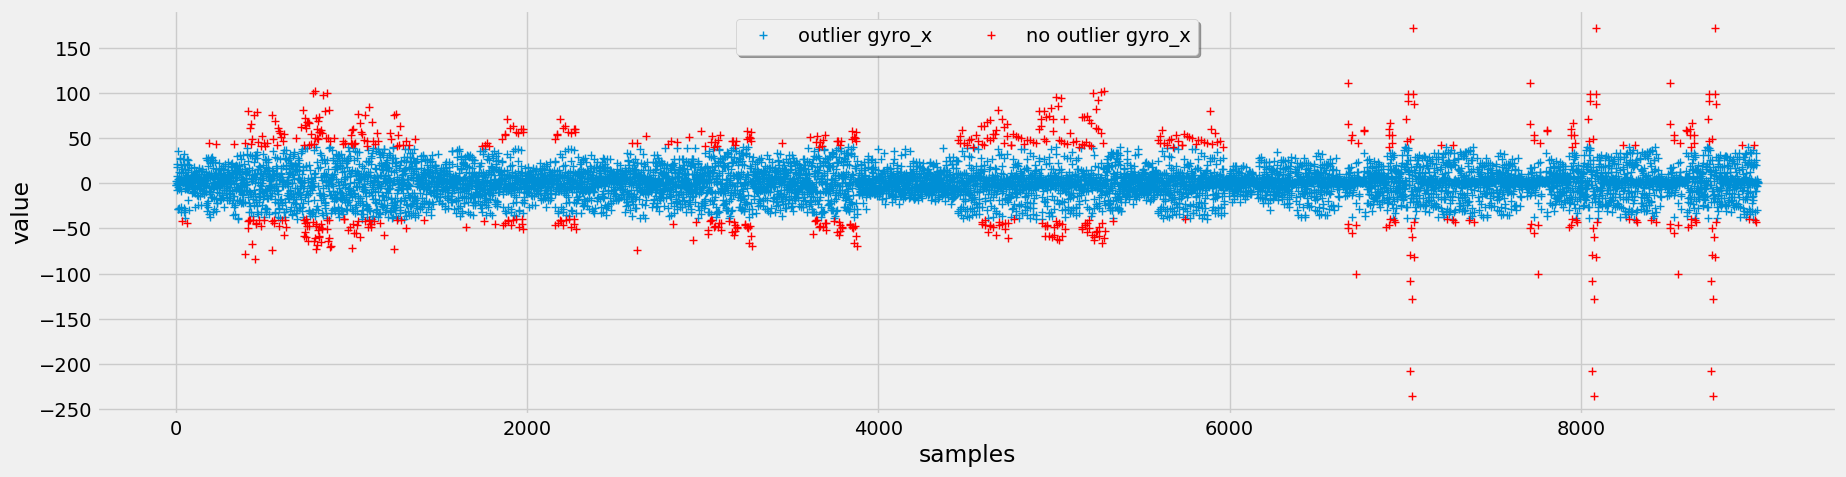

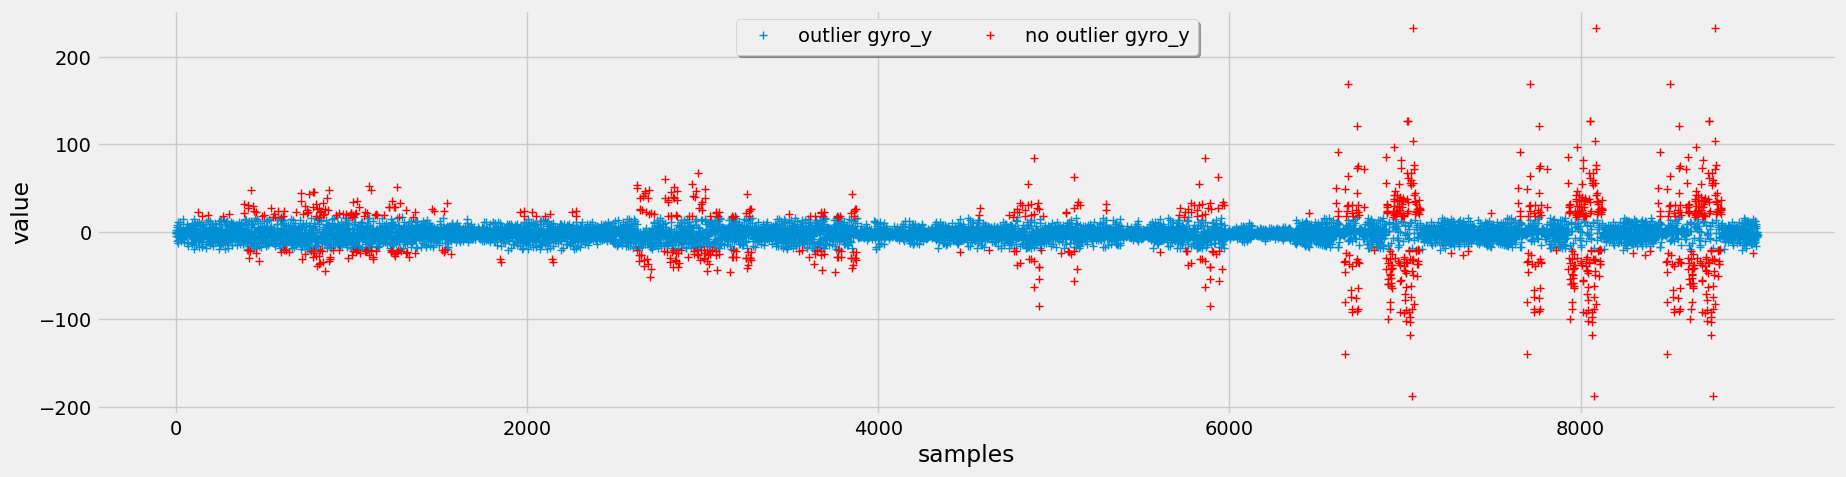

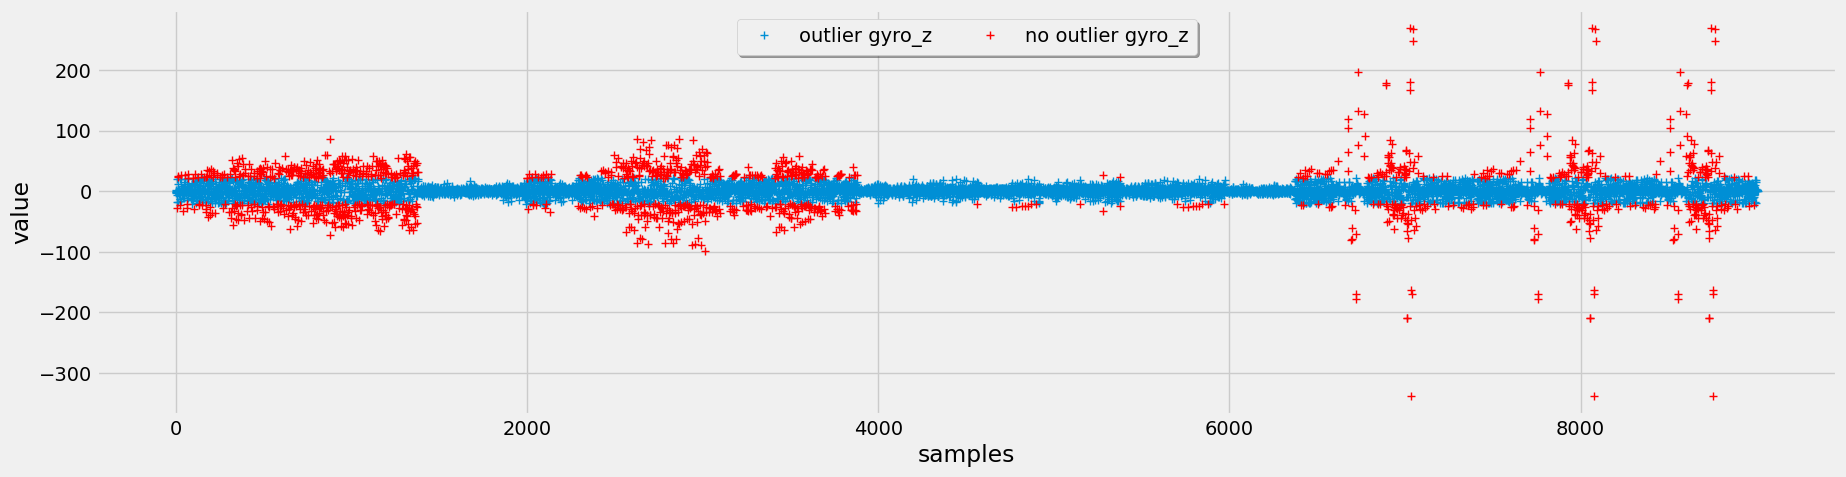

In [51]:
# Loop over all columns
for col in col_num:
  df_distribution = outliers(df, col)
  # Plot a single column
  plot_binary_outliers(df_distribution, col, f"{col}_outlier", True)

array([[<Axes: title={'center': 'bench'}, ylabel='Frequency'>,
        <Axes: title={'center': 'dead'}, ylabel='Frequency'>,
        <Axes: title={'center': 'ohp'}, ylabel='Frequency'>],
       [<Axes: title={'center': 'rest'}, ylabel='Frequency'>,
        <Axes: title={'center': 'row'}, ylabel='Frequency'>,
        <Axes: title={'center': 'squat'}, ylabel='Frequency'>],
       [<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
        <Axes: ylabel='Frequency'>]], dtype=object)

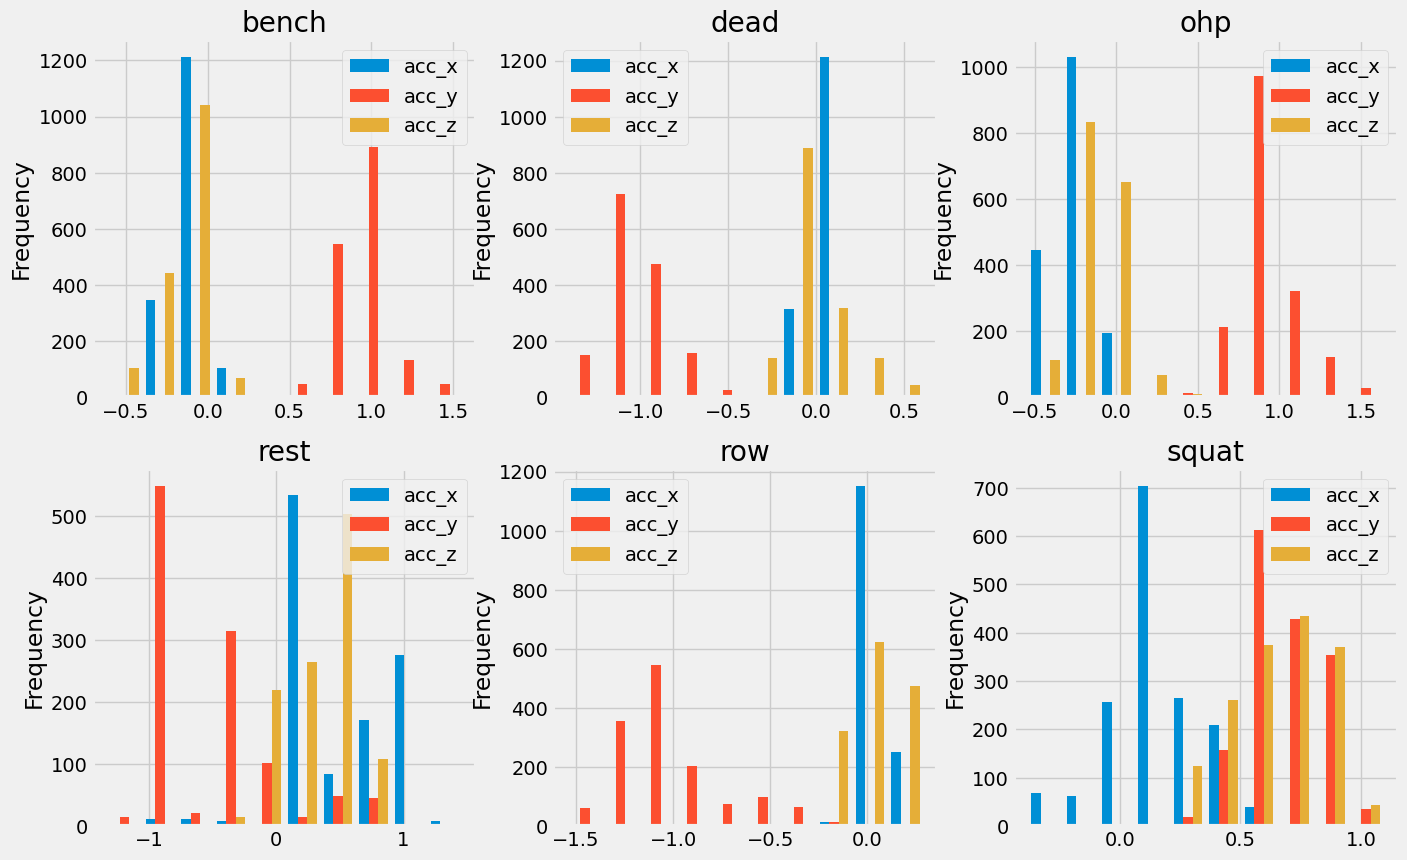

In [52]:
# --------------------------------------------------------------
# Chauvenets criteron (distribution based)
# --------------------------------------------------------------

# Check for normal distribution
df[col_num[:3] + ["excercise"]].plot(by = "excercise",
                                kind = "hist",
                                figsize = (15, 15),
                                label = "excercise",
                                     layout = (3, 3))


array([[<Axes: title={'center': 'bench'}, ylabel='Frequency'>,
        <Axes: title={'center': 'dead'}, ylabel='Frequency'>,
        <Axes: title={'center': 'ohp'}, ylabel='Frequency'>],
       [<Axes: title={'center': 'rest'}, ylabel='Frequency'>,
        <Axes: title={'center': 'row'}, ylabel='Frequency'>,
        <Axes: title={'center': 'squat'}, ylabel='Frequency'>],
       [<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
        <Axes: ylabel='Frequency'>]], dtype=object)

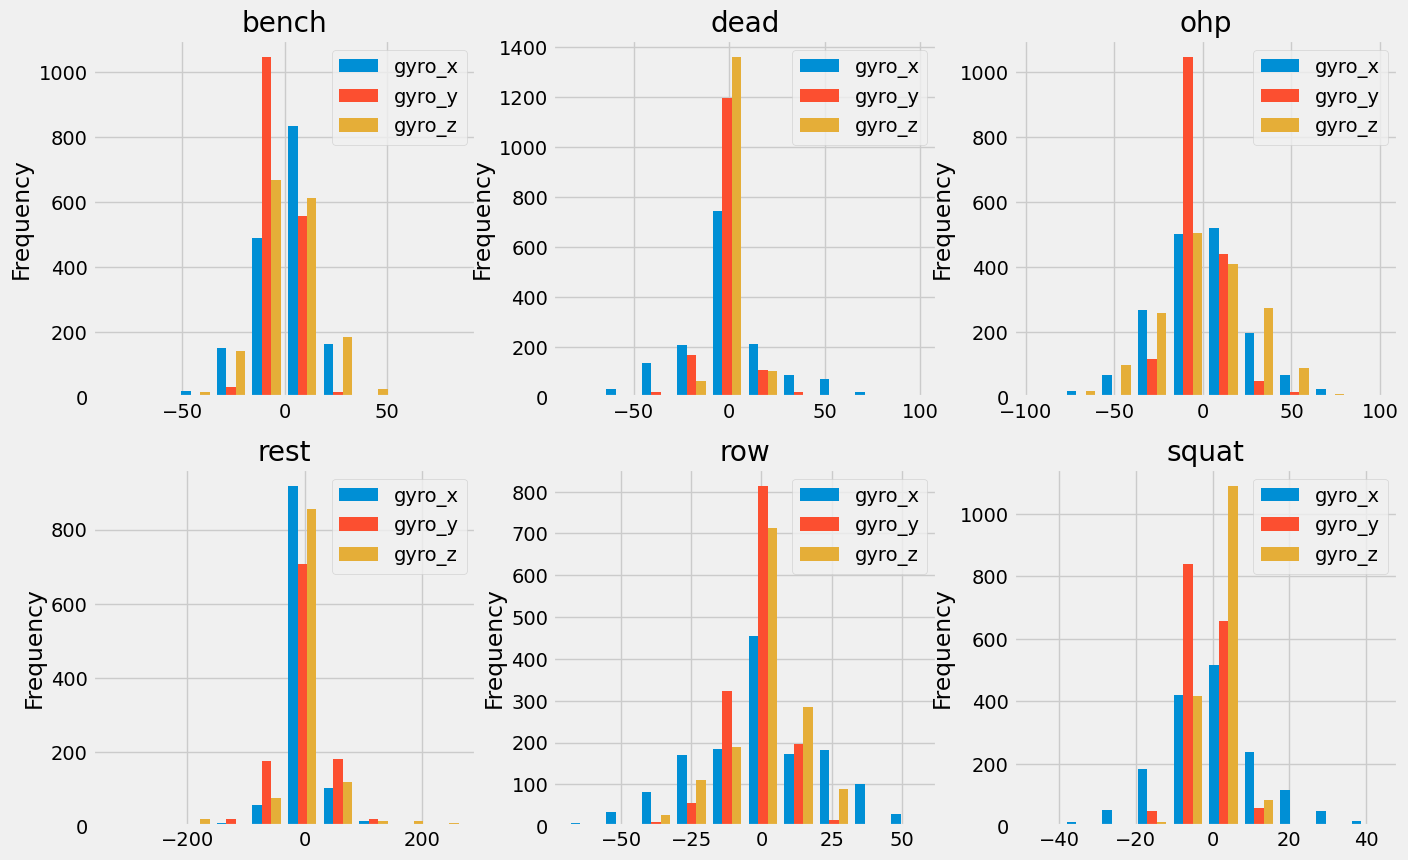

In [53]:
df[col_num[3:6] + ["excercise"]].plot(by = "excercise",
                                kind = "hist",
                                figsize = (15, 15),
                                label = "excercise",
                                     layout = (3, 3))

In [54]:
# Insert Chauvenet's function
def mark_outliers_chauvenet(dataset, col, C=2):
    """Finds outliers in the specified column of datatable and adds a binary column with
    the same name extended with '_outlier' that expresses the result per data point.

    Taken from: https://github.com/mhoogen/ML4QS/blob/master/Python3Code/Chapter3/OutlierDetection.py

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        C (int, optional): Degree of certainty for the identification of outliers given the assumption
                           of a normal distribution, typicaly between 1 - 10. Defaults to 2.

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()
    # Compute the mean and standard deviation.
    mean = dataset[col].mean()
    std = dataset[col].std()
    N = len(dataset.index)
    criterion = 1.0 / (C * N)

    # Consider the deviation for the data points.
    deviation = abs(dataset[col] - mean) / std

    # Express the upper and lower bounds.
    low = -deviation / math.sqrt(C)
    high = deviation / math.sqrt(C)
    prob = []
    mask = []

    # Pass all rows in the dataset.
    for i in range(0, len(dataset.index)):
        # Determine the probability of observing the point
        prob.append(
            1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
        )
        # And mark as an outlier when the probability is below our criterion.
        mask.append(prob[i] < criterion)
    dataset[col + "_outlier"] = mask
    return dataset

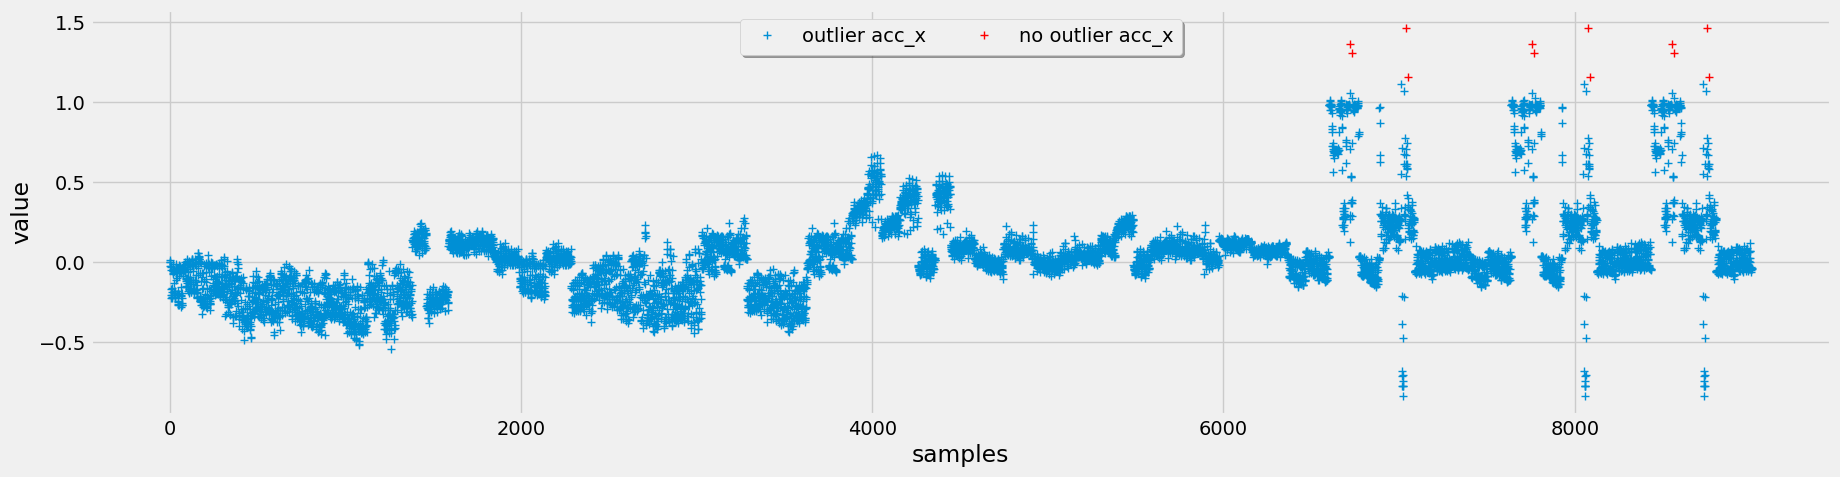

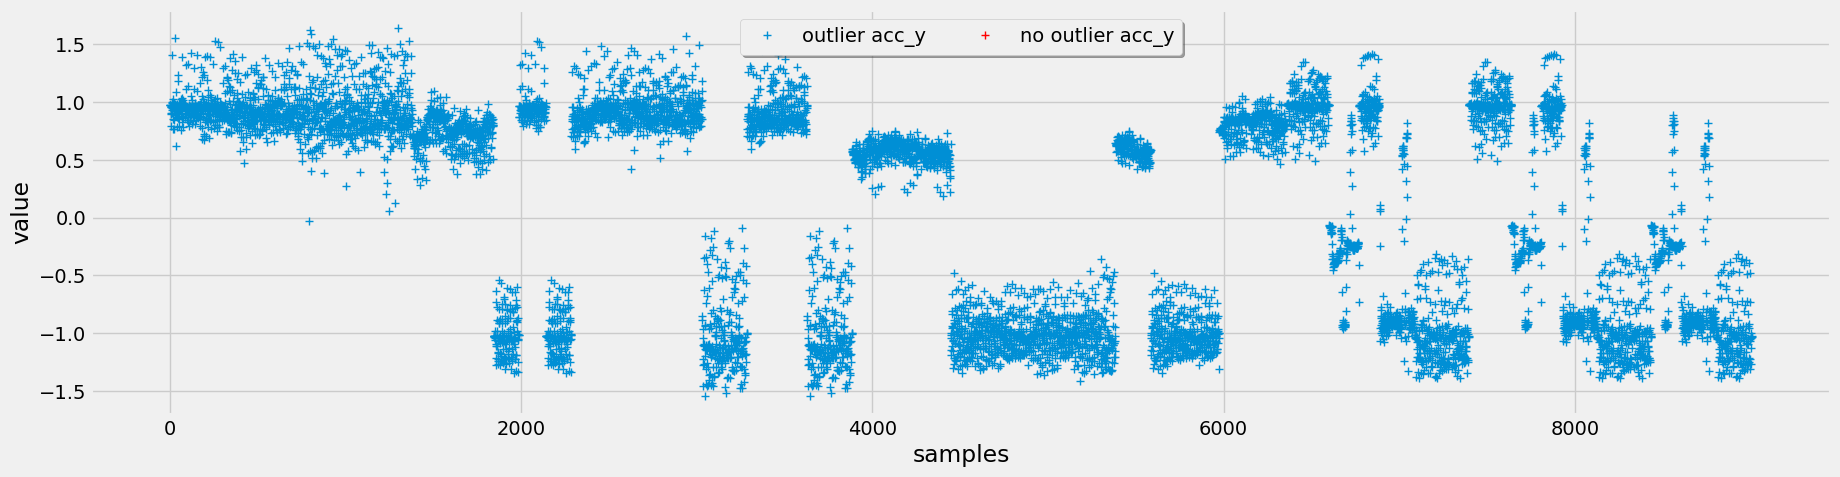

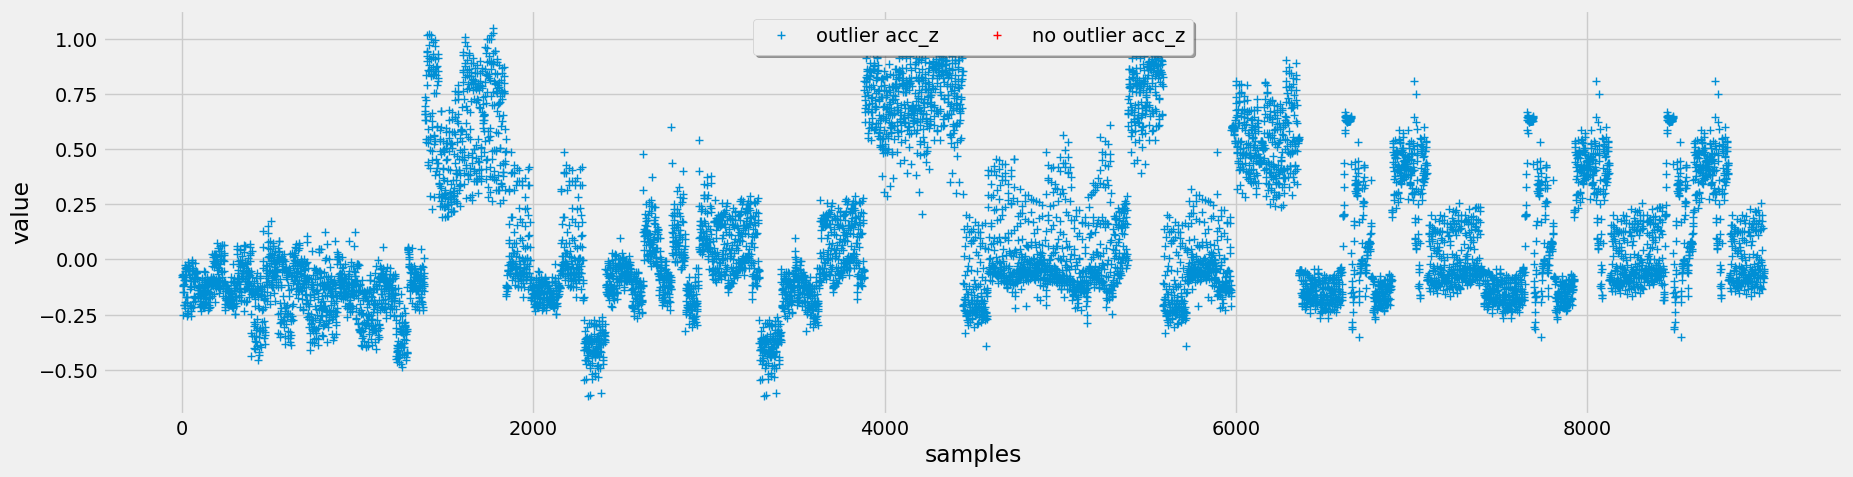

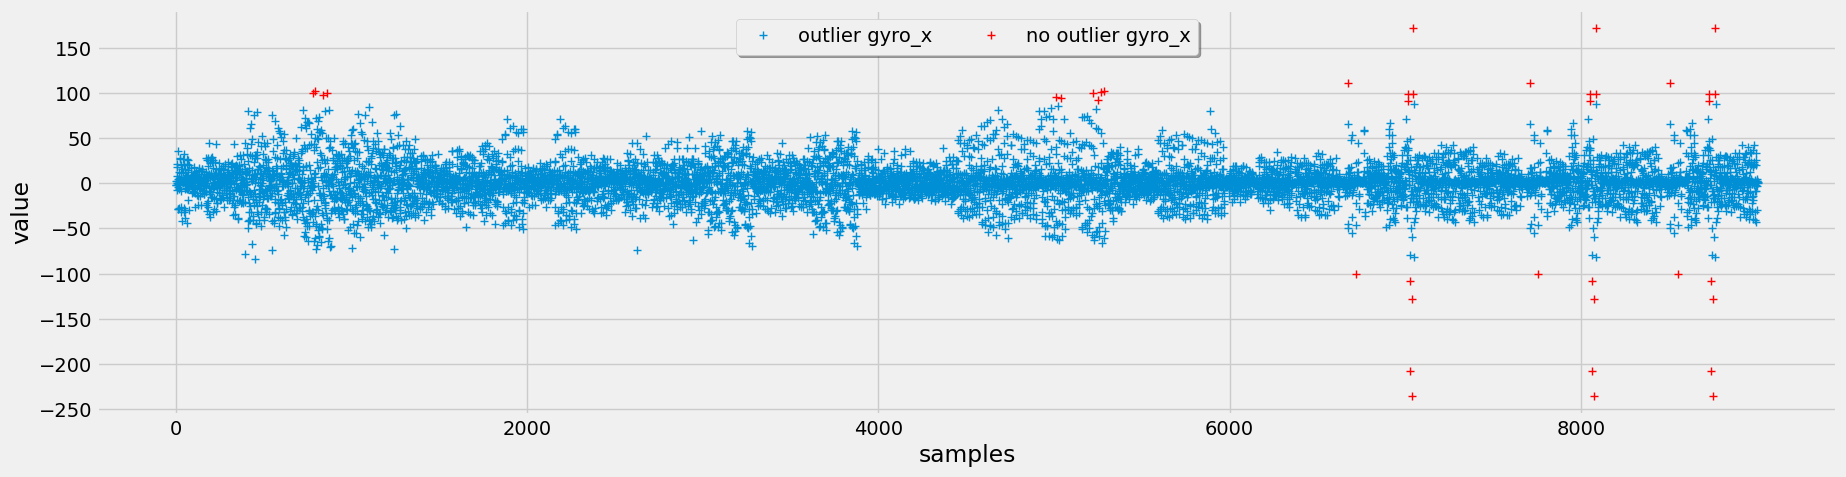

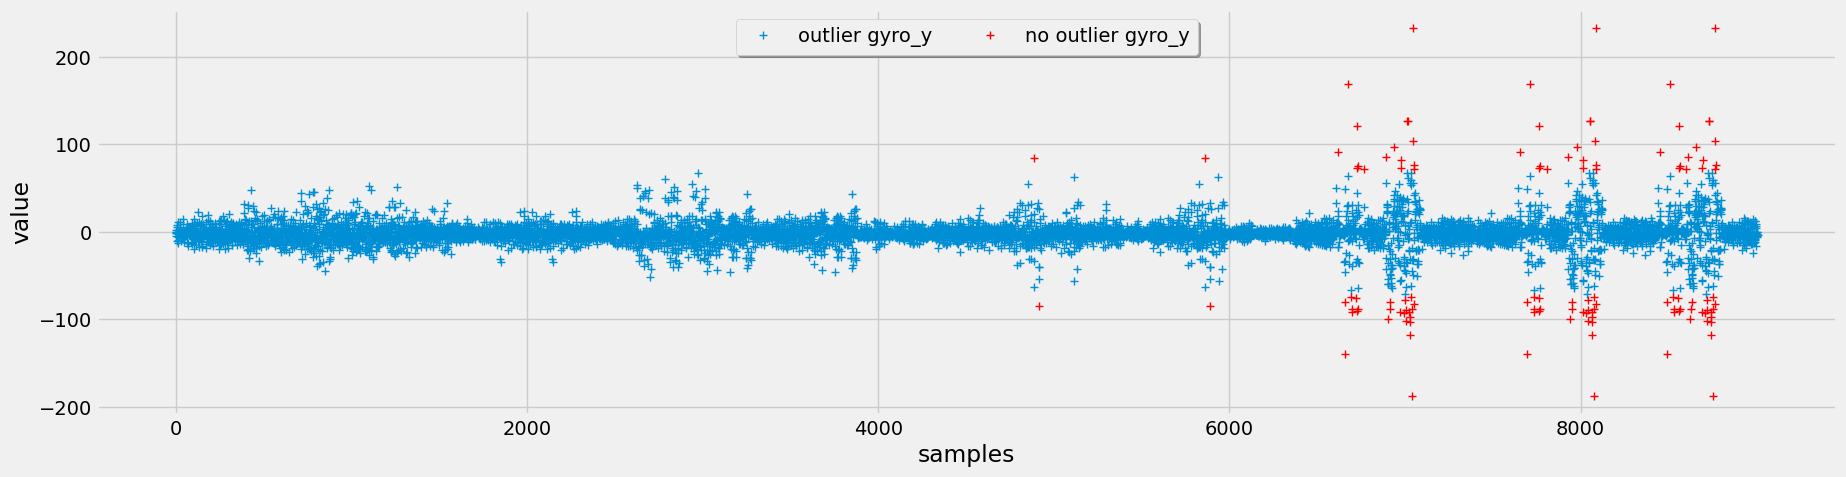

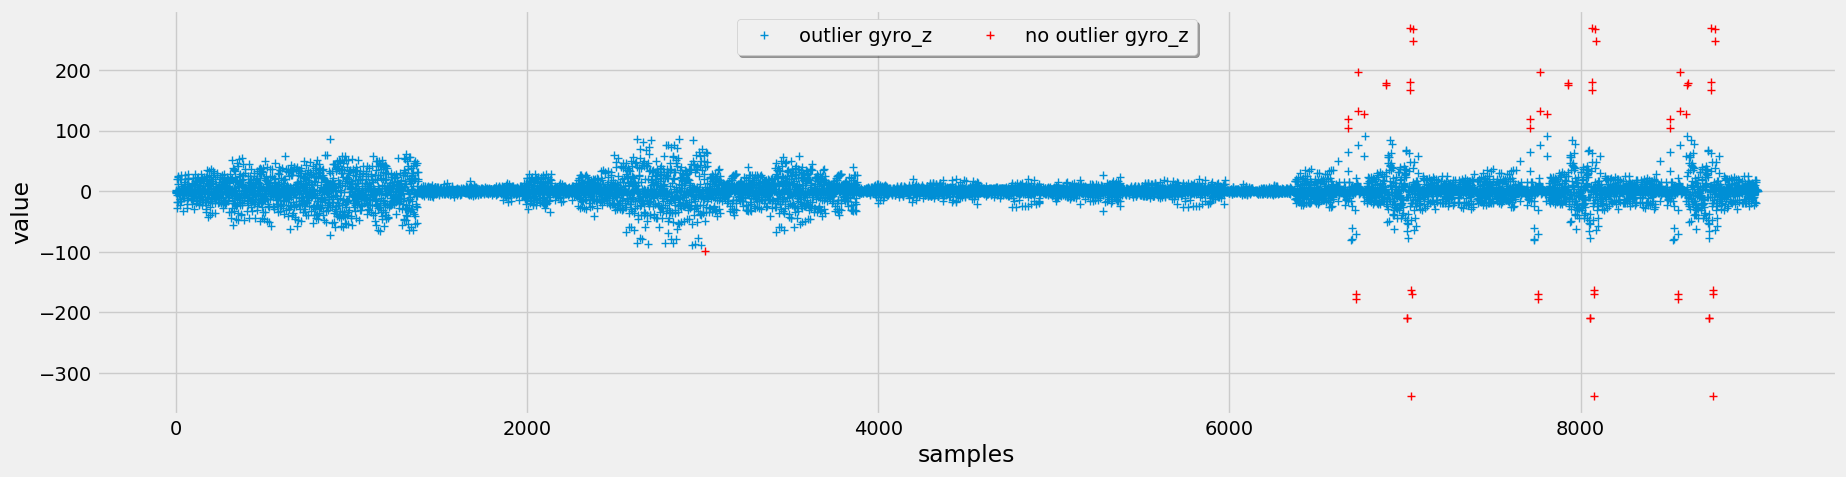

In [55]:
# Loop over all columns
for col in col_num:
  df_chauv = mark_outliers_chauvenet(df, col, C=2)
  # Plot a single column
  plot_binary_outliers(df_chauv, col, f"{col}_outlier", True)

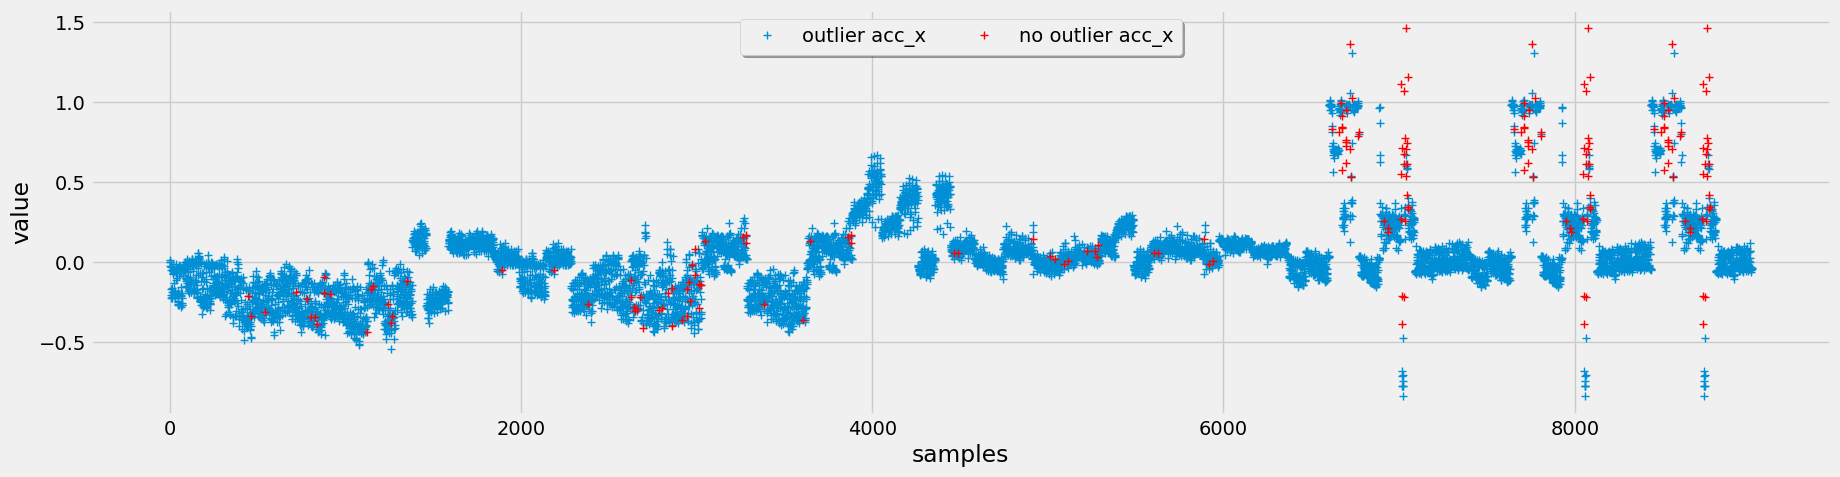

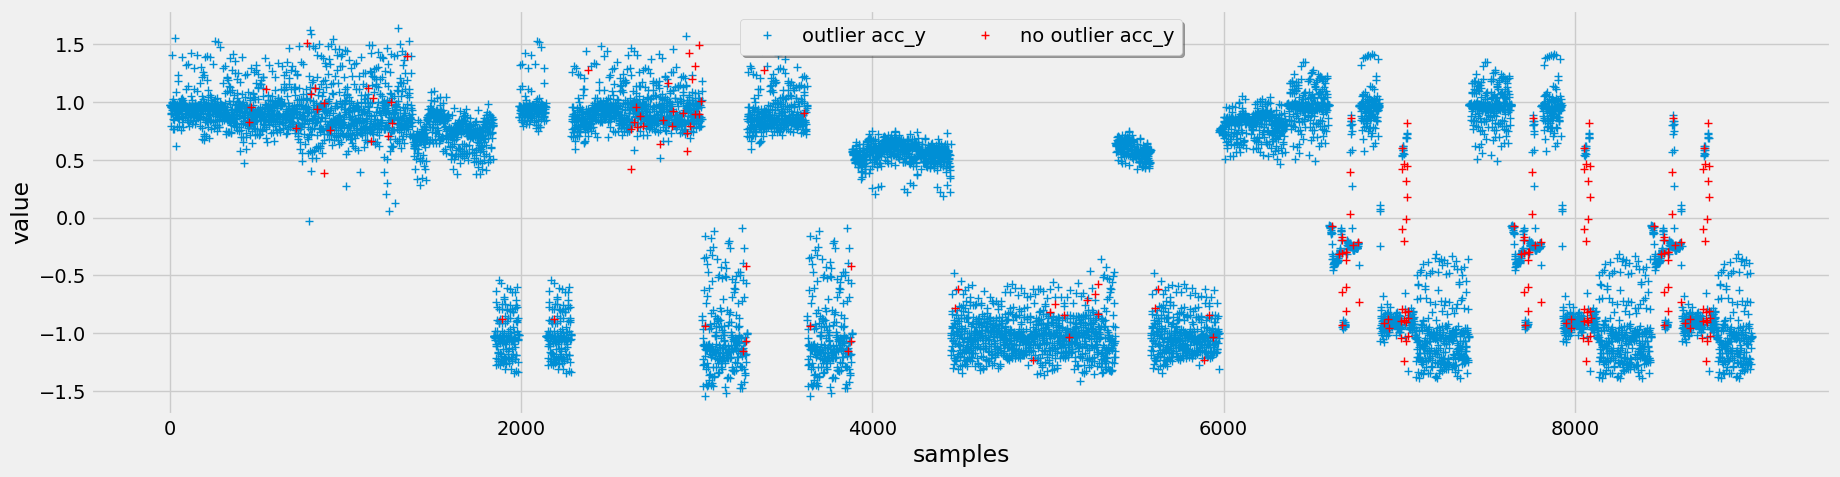

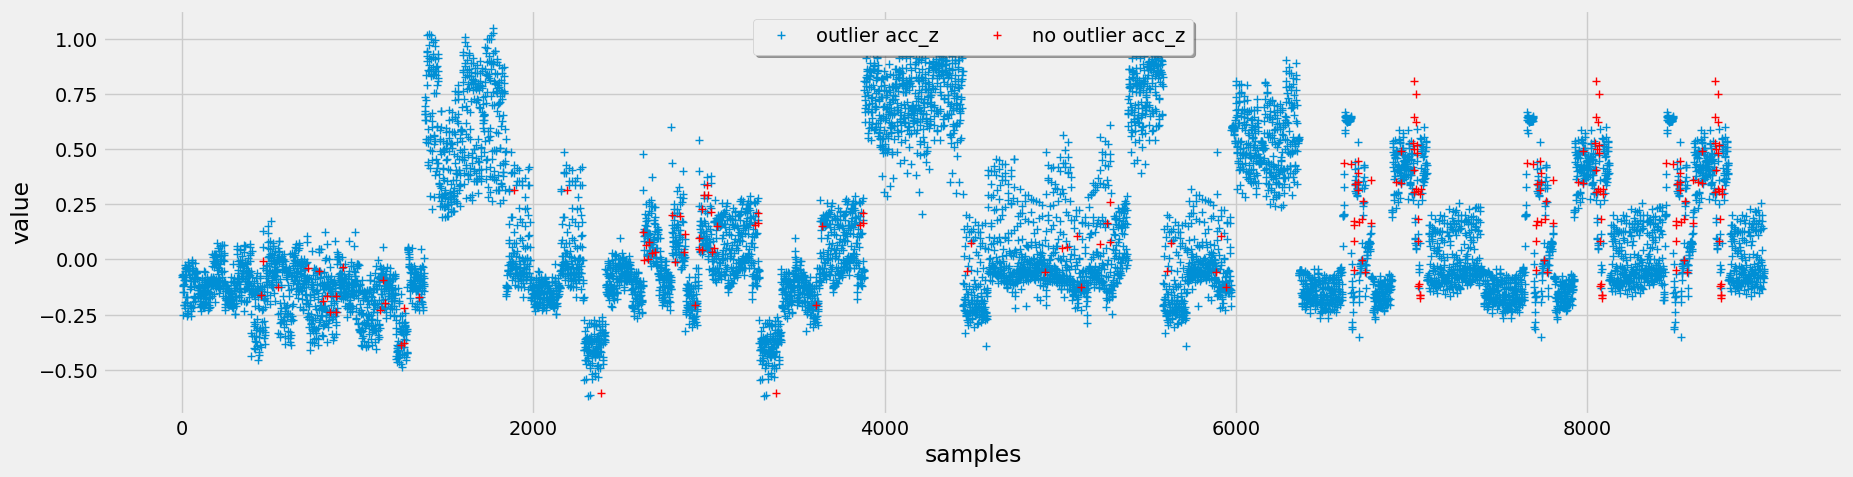

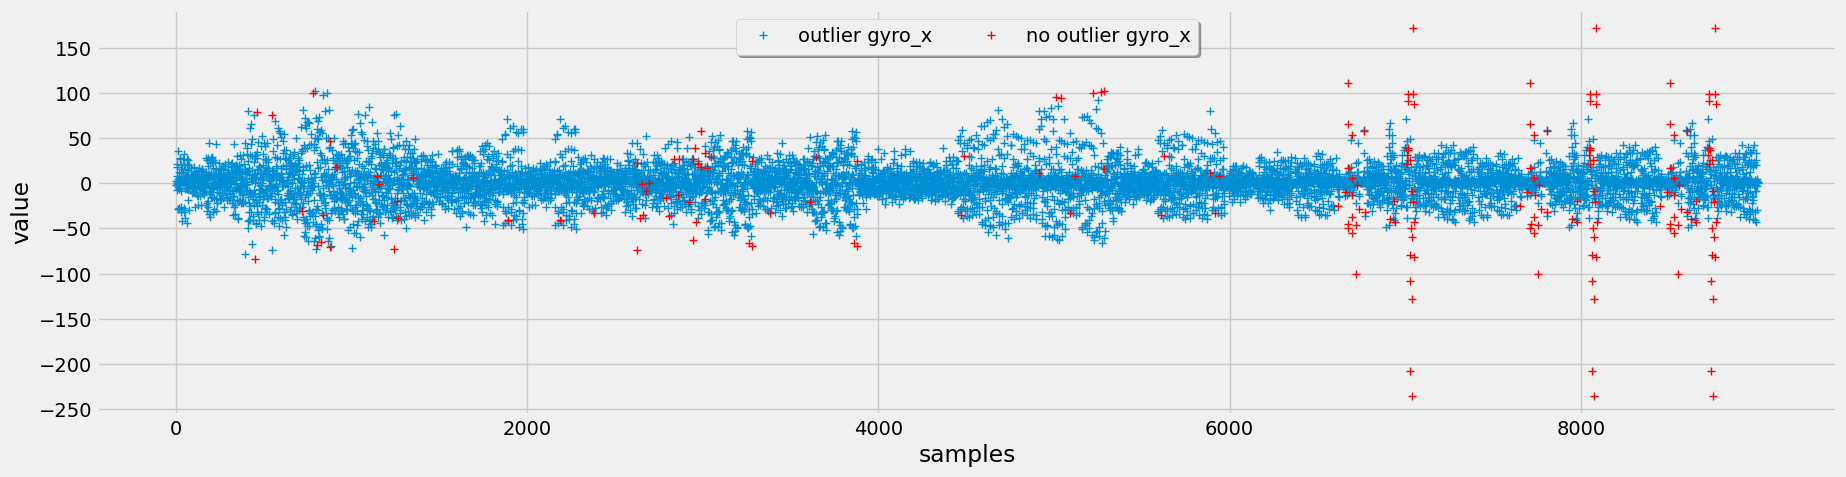

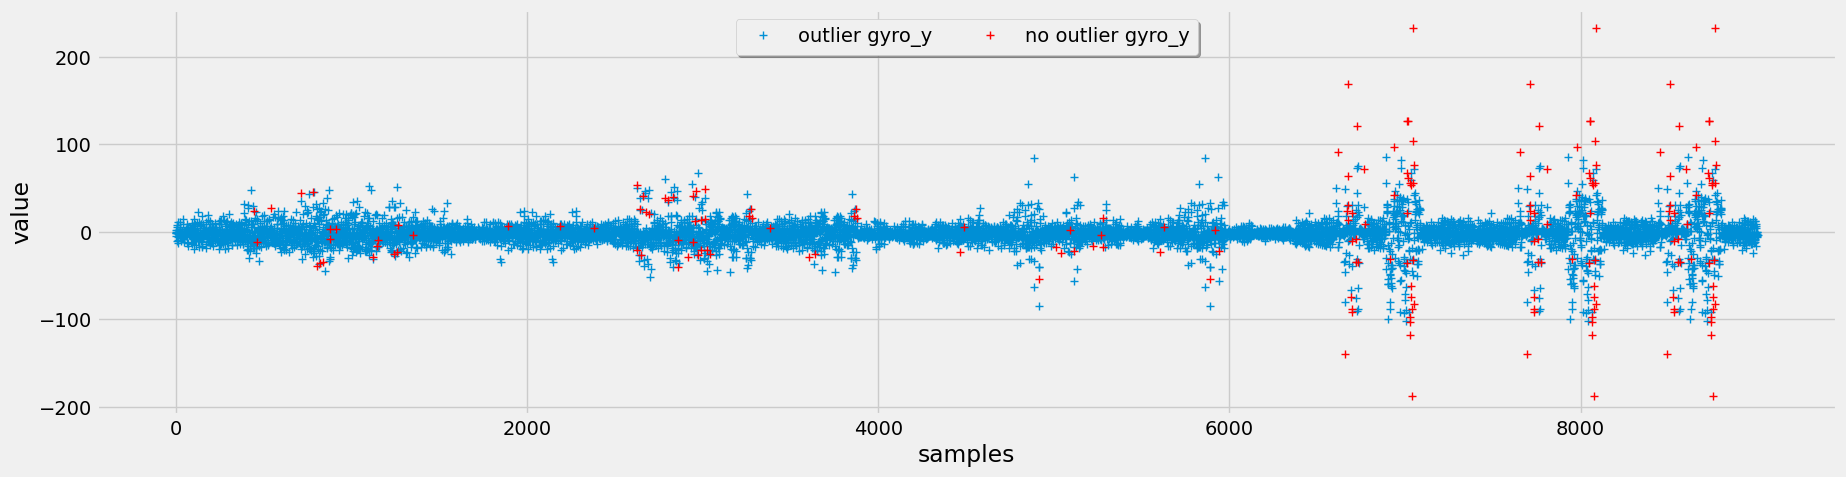

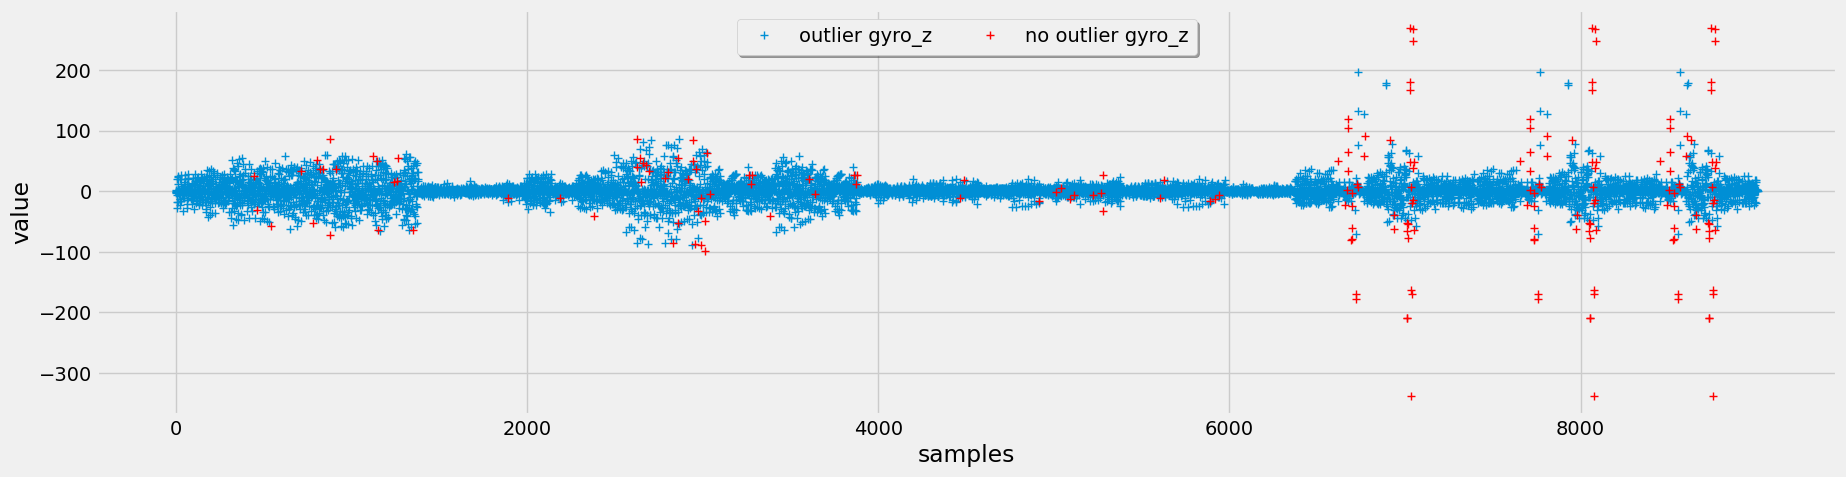

In [56]:
# --------------------------------------------------------------
# Local outlier factor (distance based)
# --------------------------------------------------------------

# Insert LOF function
def mark_outliers_lof(dataset, columns, n=20):
    """Mark values as outliers using LOF

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        n (int, optional): n_neighbors. Defaults to 20.

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()

    lof = LocalOutlierFactor(n_neighbors=n)
    data = dataset[columns]
    outliers = lof.fit_predict(data)
    X_scores = lof.negative_outlier_factor_

    dataset["outlier_lof"] = outliers == -1
    return dataset, outliers, X_scores

# Loop over all columns
df_loc, outliers, X_scores = mark_outliers_lof(df, col_num, n=20)
# Plot a single column
for col in col_num:
  plot_binary_outliers(df_loc, col, "outlier_lof", True)

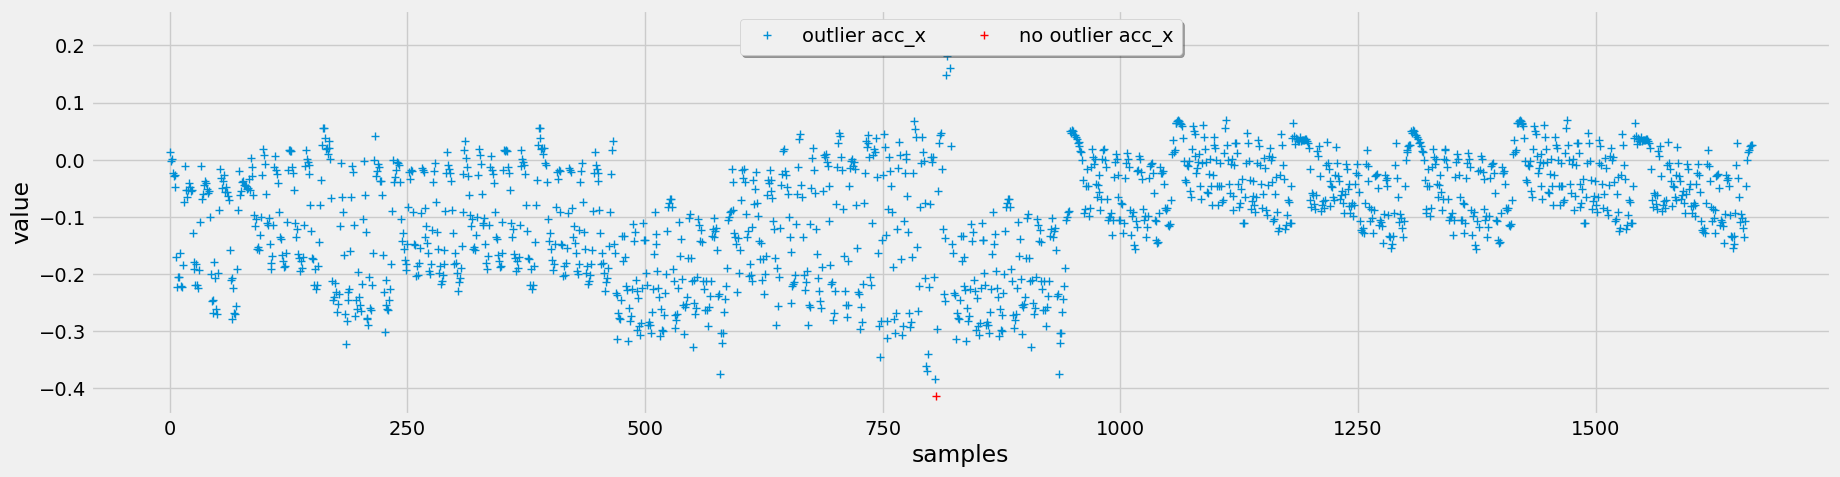

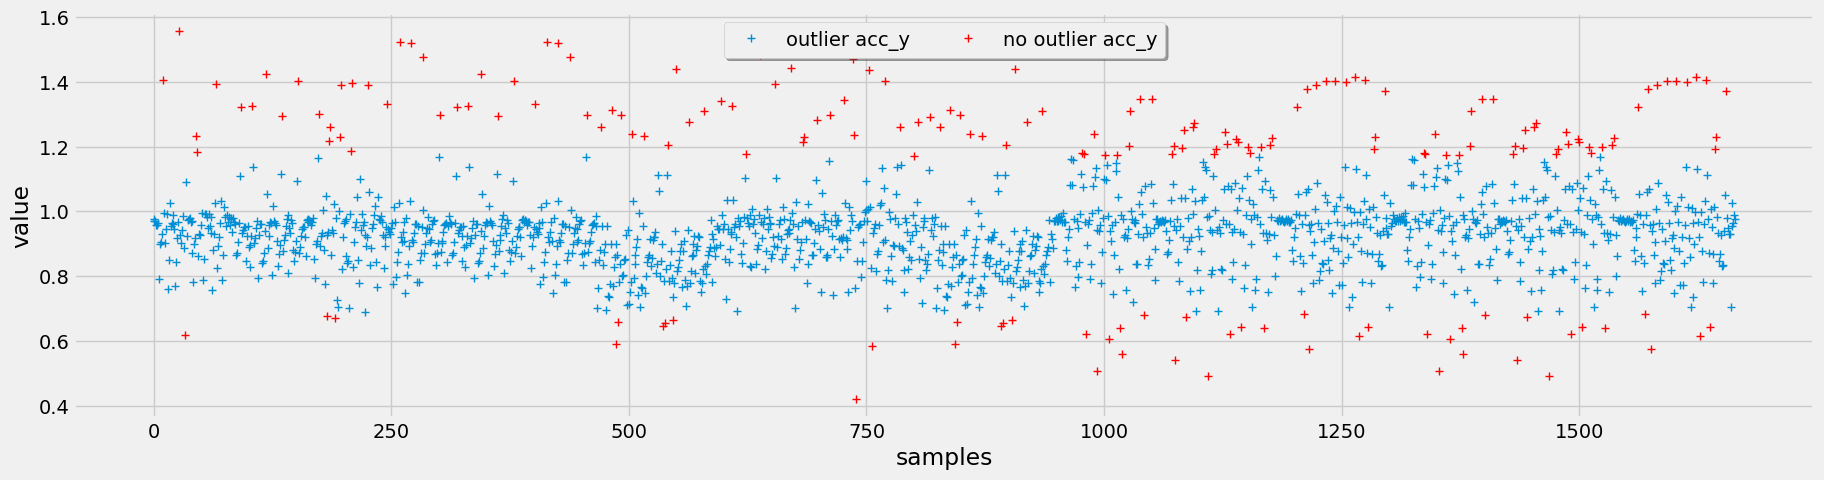

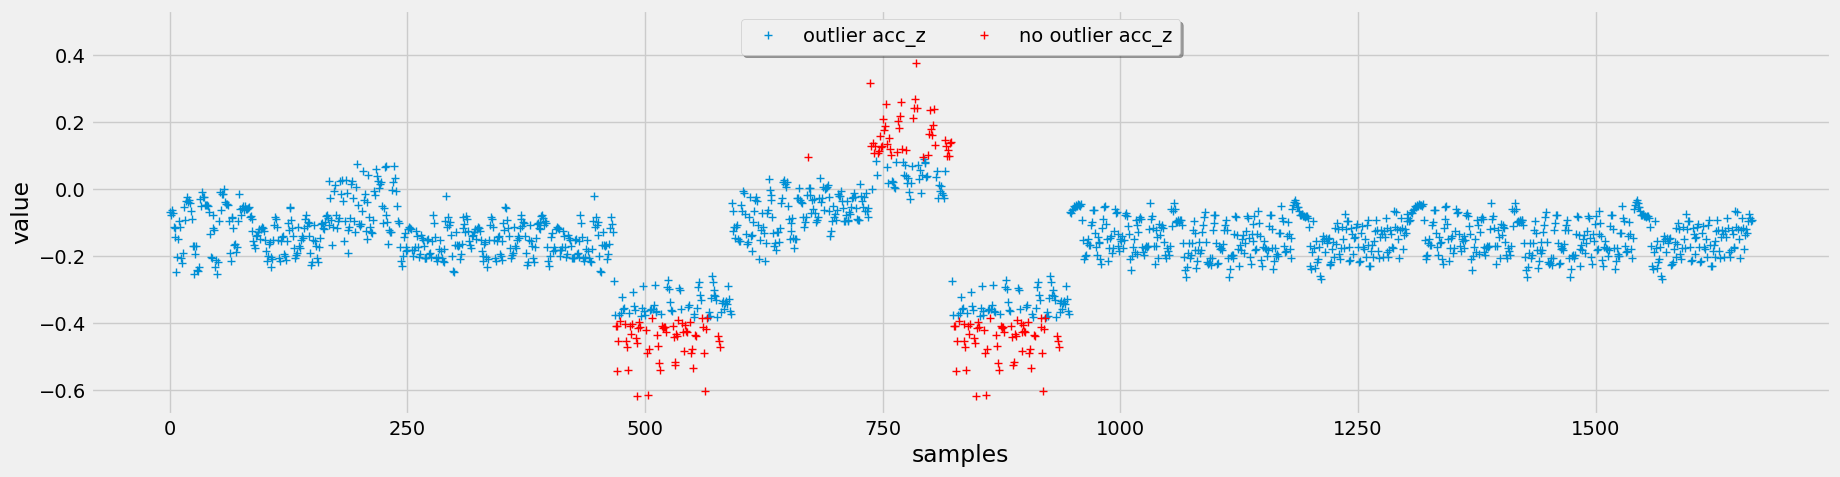

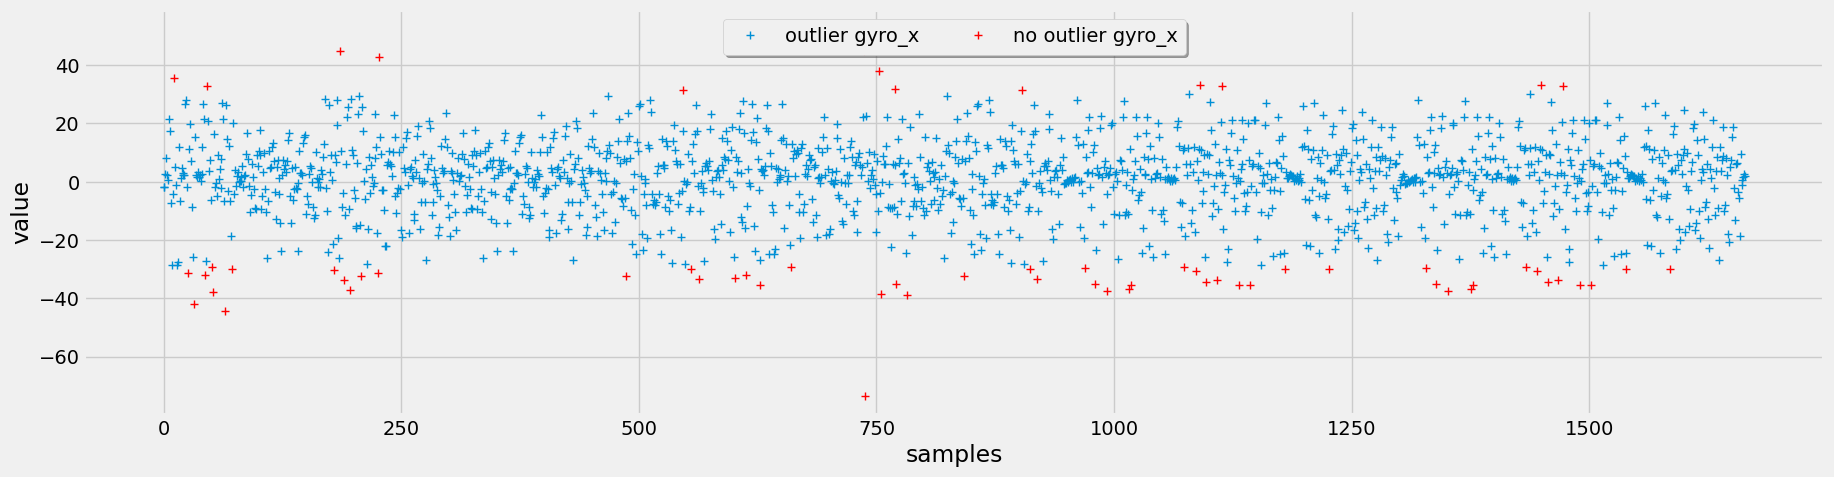

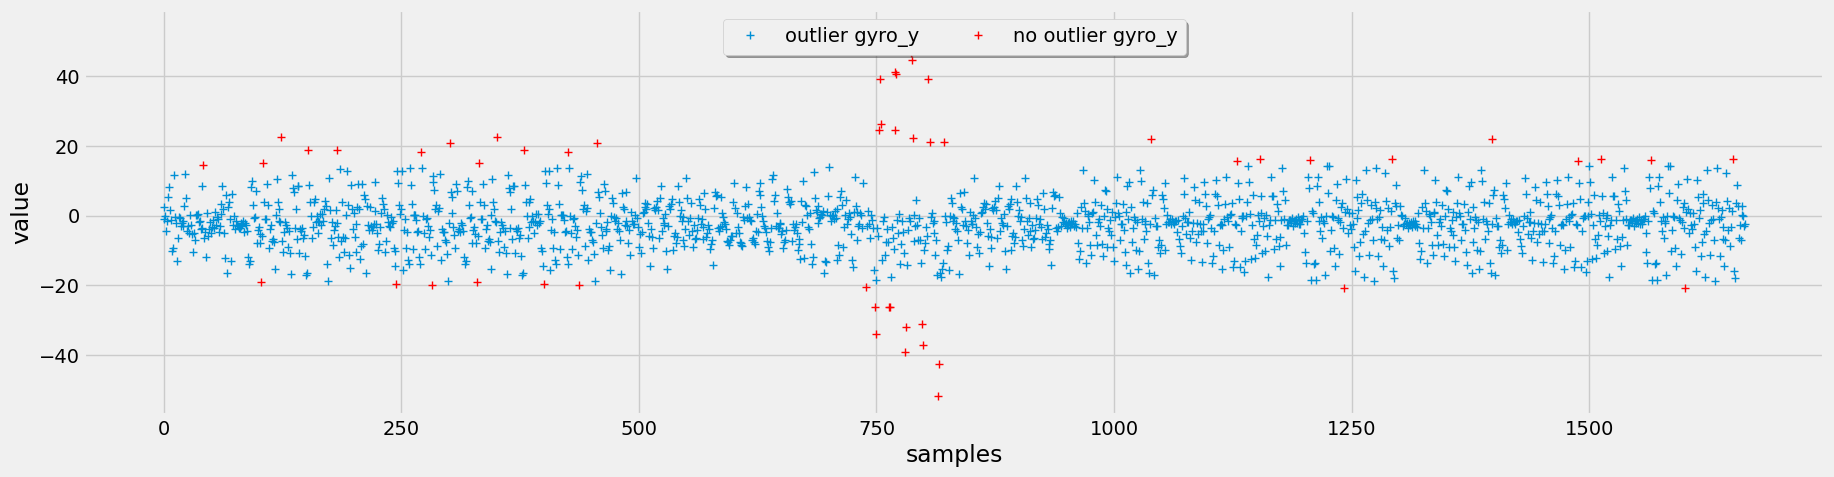

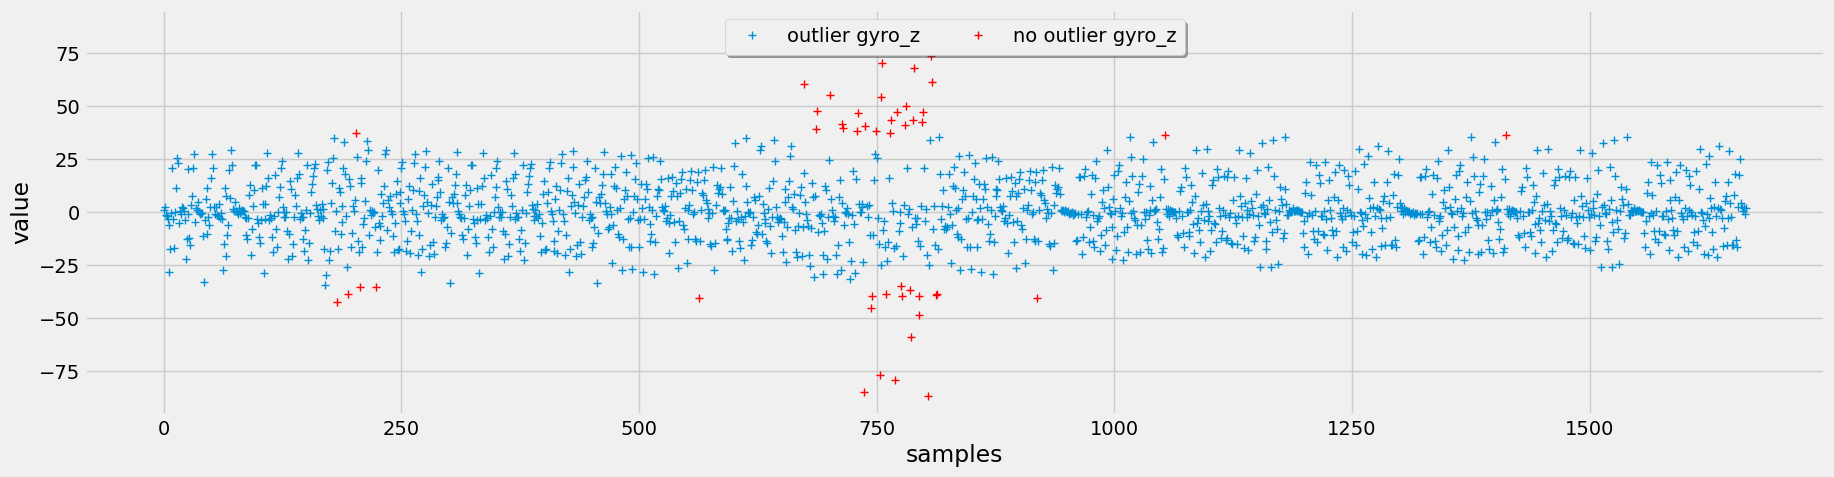

In [61]:
# --------------------------------------------------------------
# Check outliers grouped by label
# --------------------------------------------------------------
# Loop over all columns
label = "bench"
for col in col_num:
  df_iqr_label = mark_outliers_iqr(df[df["excercise"] == label], col)
  # Plot a single column
  plot_binary_outliers(df_iqr_label, col, f"{col}_outlier", True)


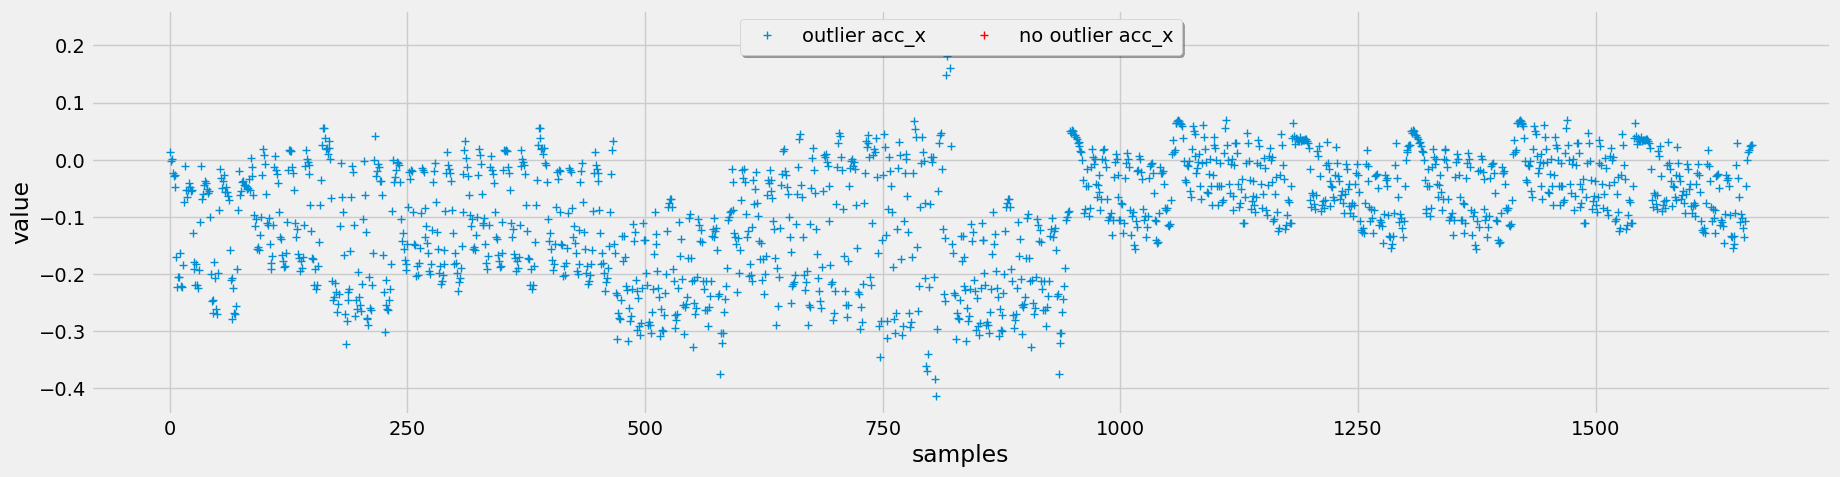

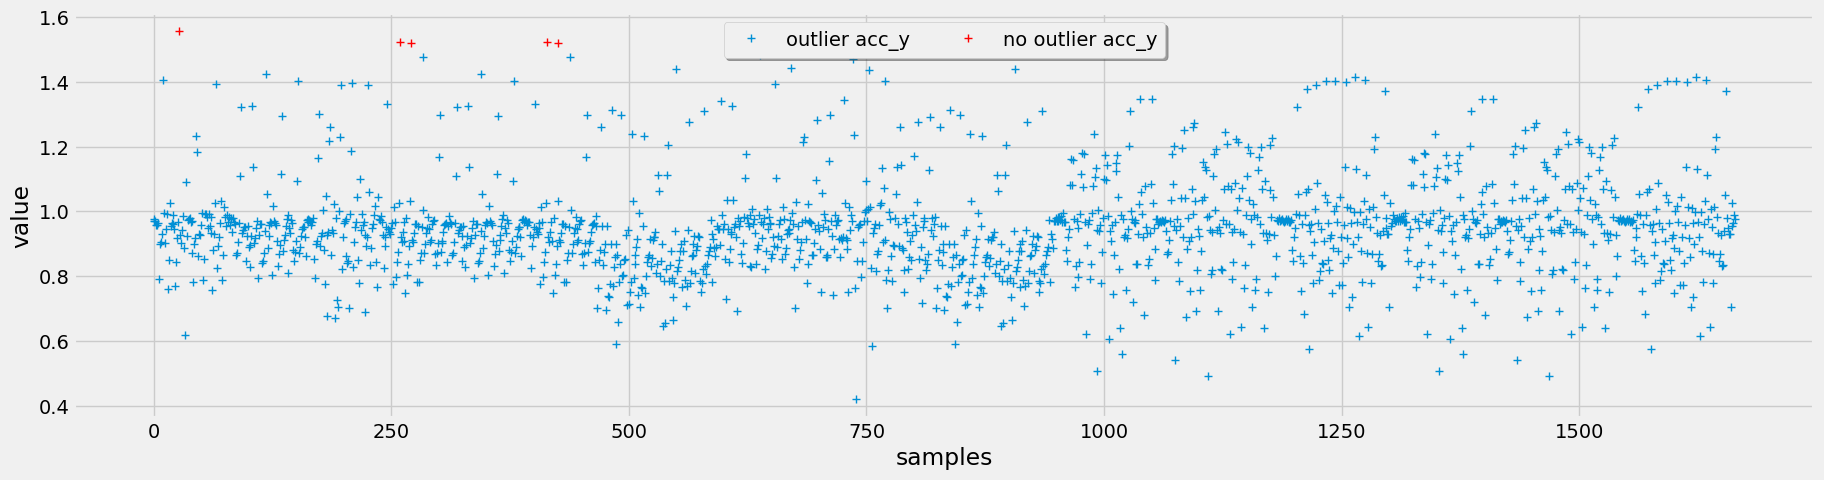

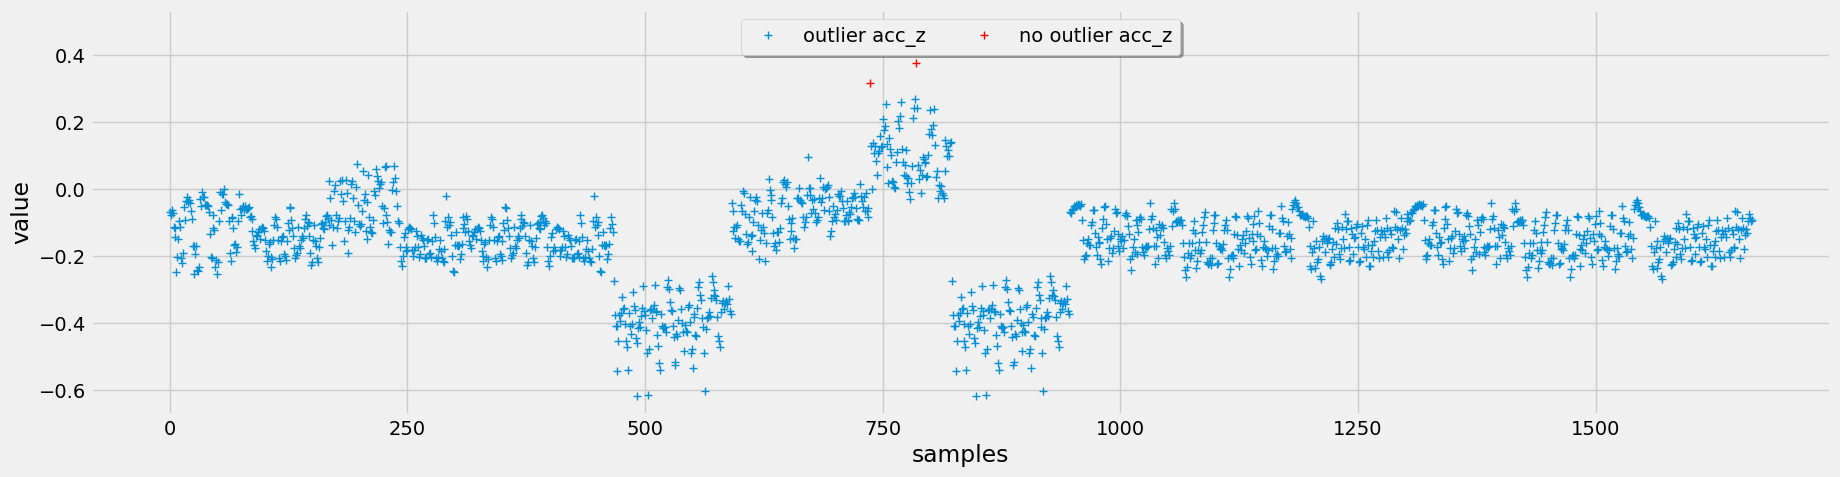

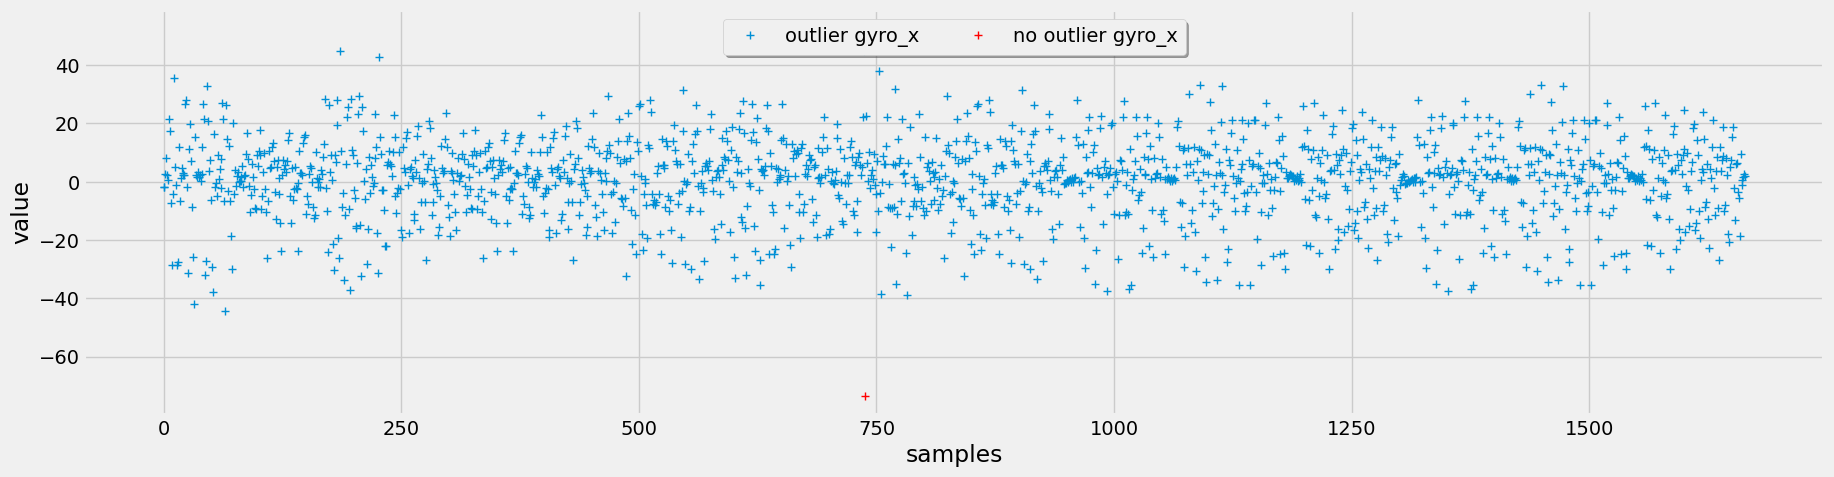

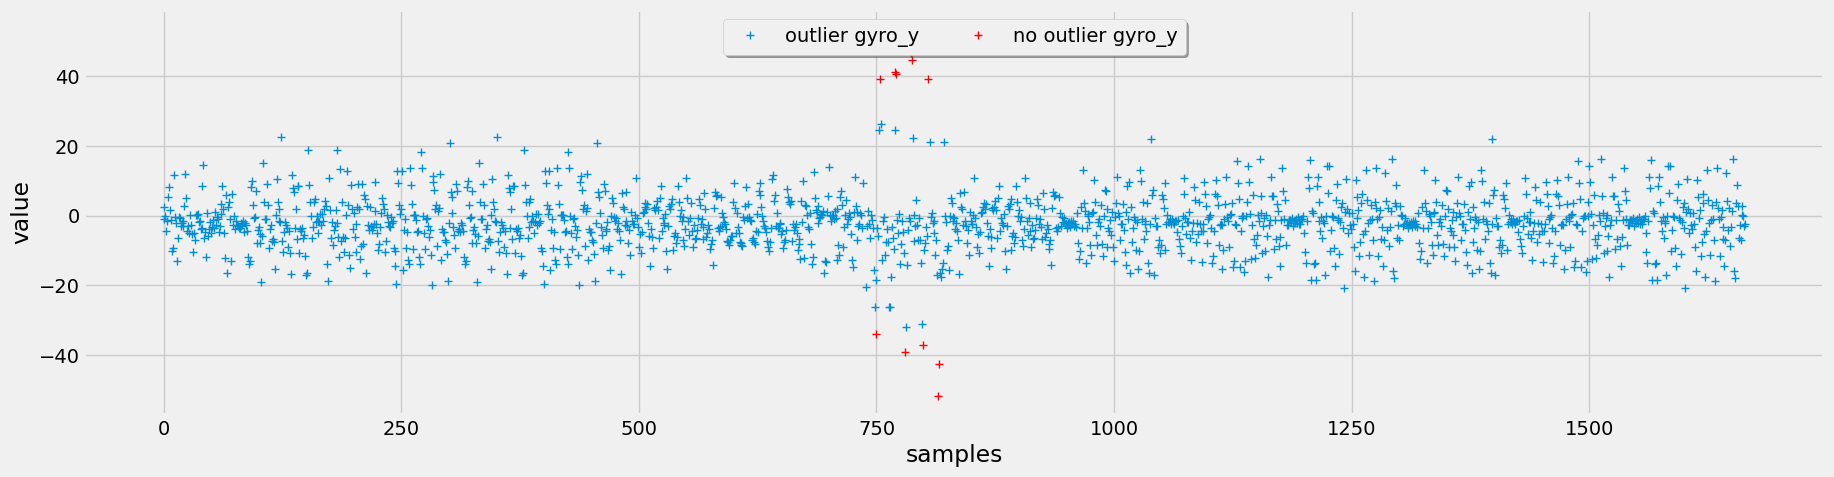

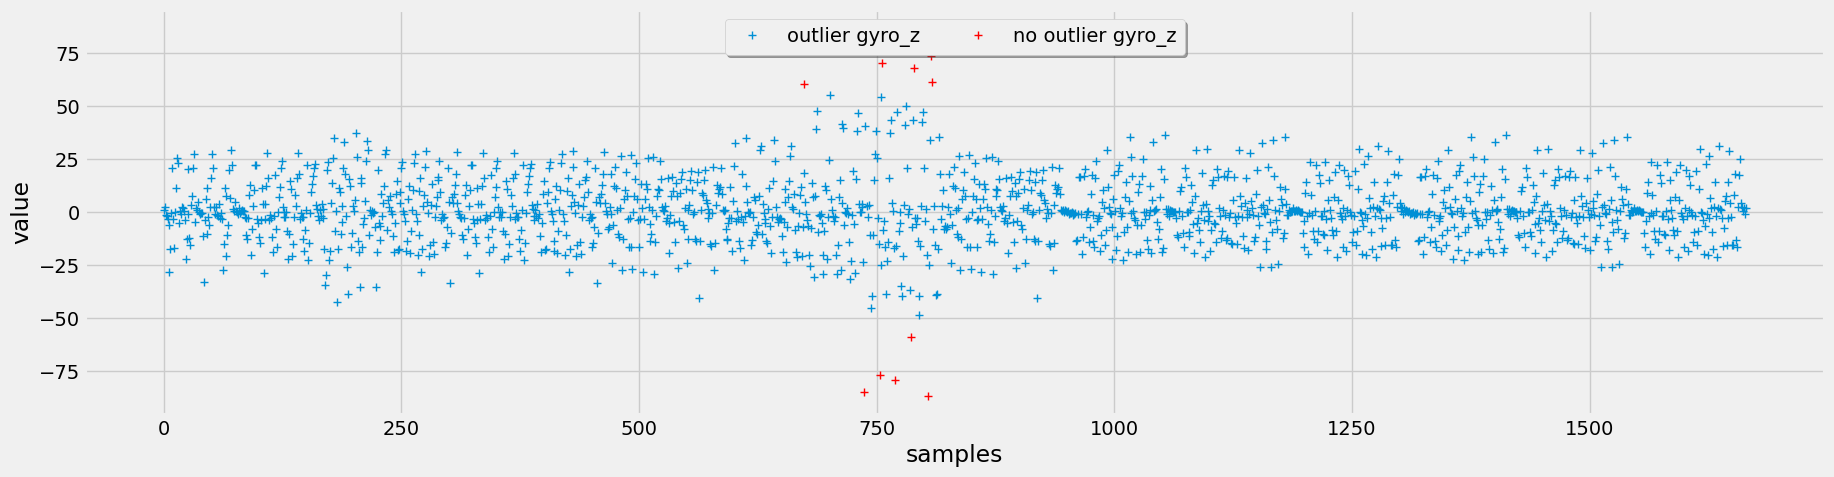

In [62]:
# Usign Chavenet
for col in col_num:
  df_chauv_label = mark_outliers_chauvenet(df[df["excercise"] == label], col)
  # Plot a single column
  plot_binary_outliers(df_chauv_label, col, f"{col}_outlier", True)


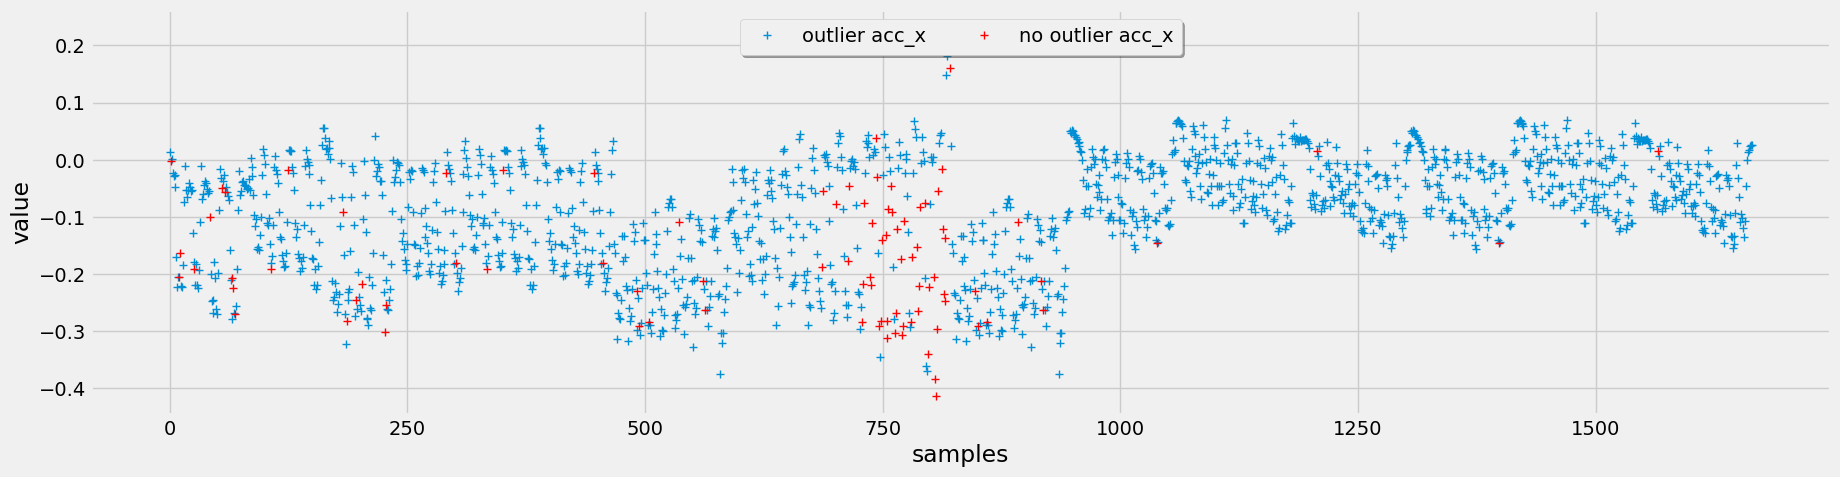

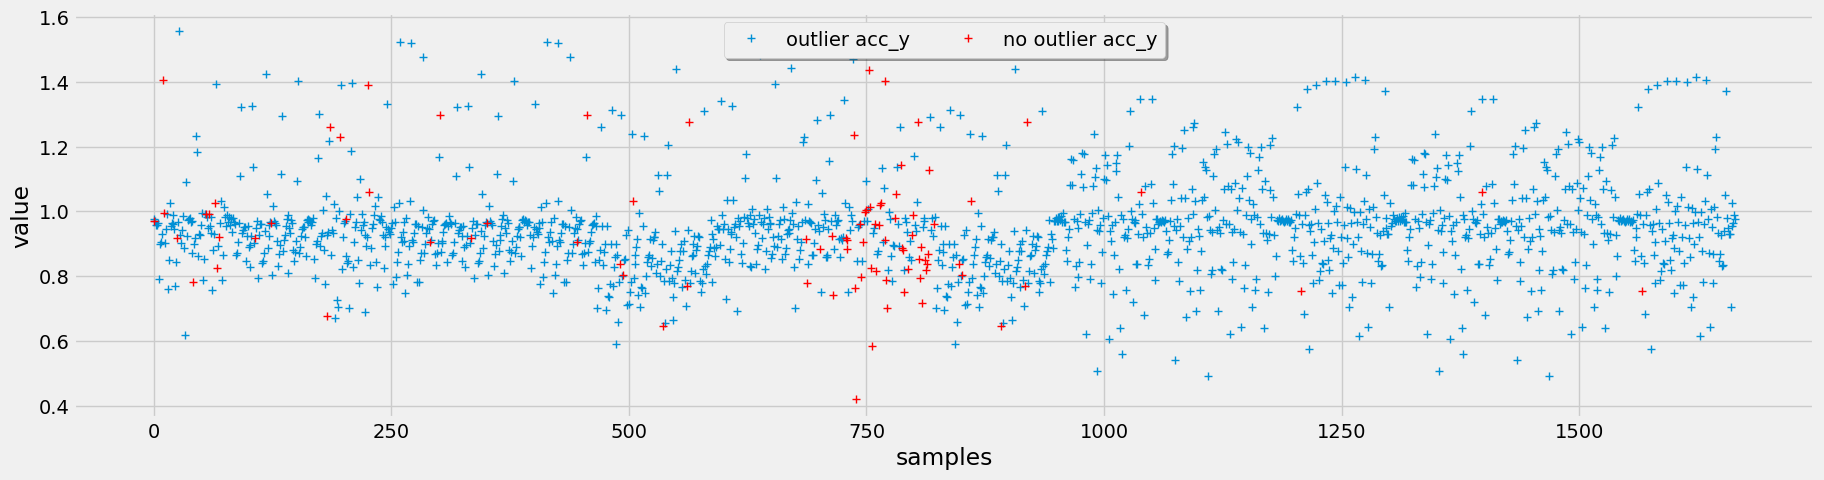

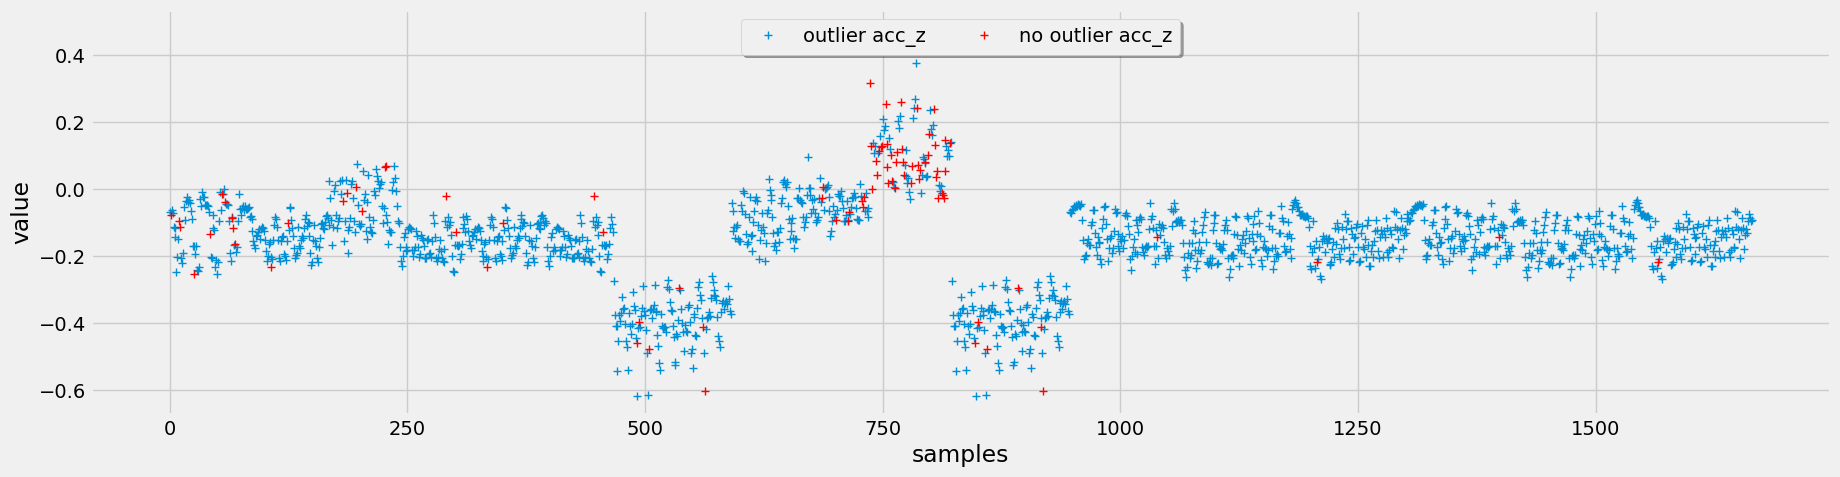

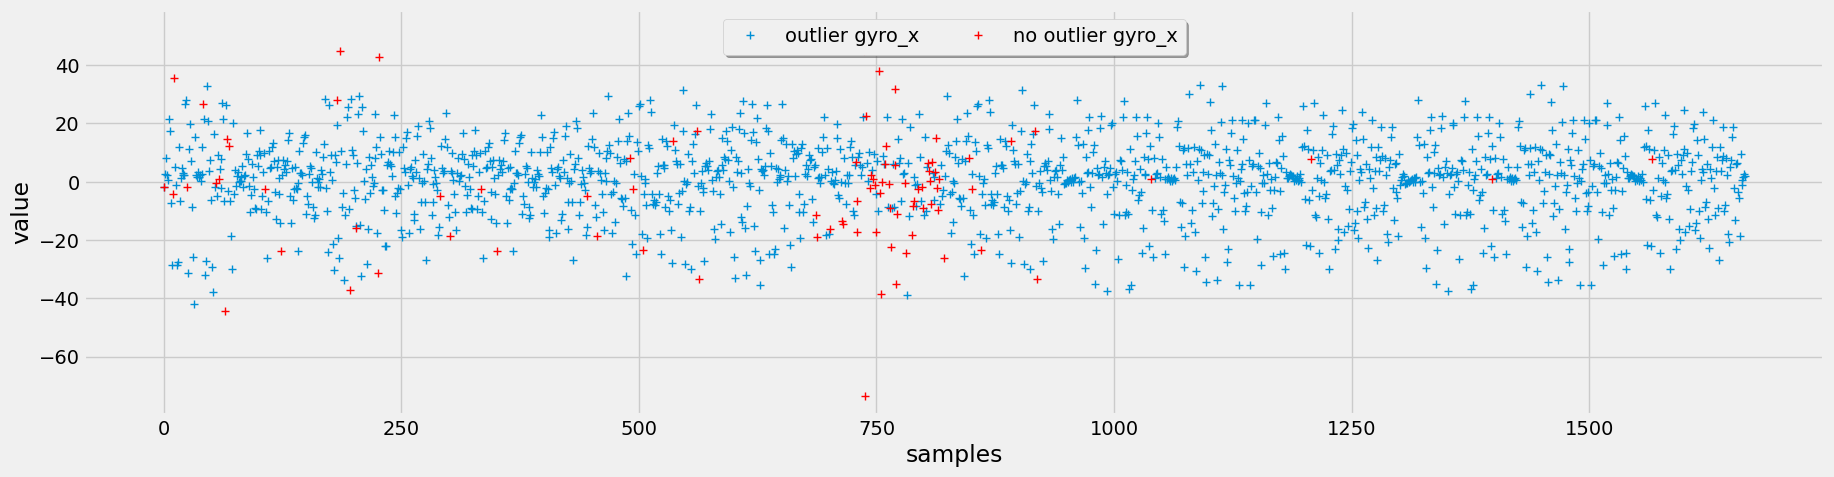

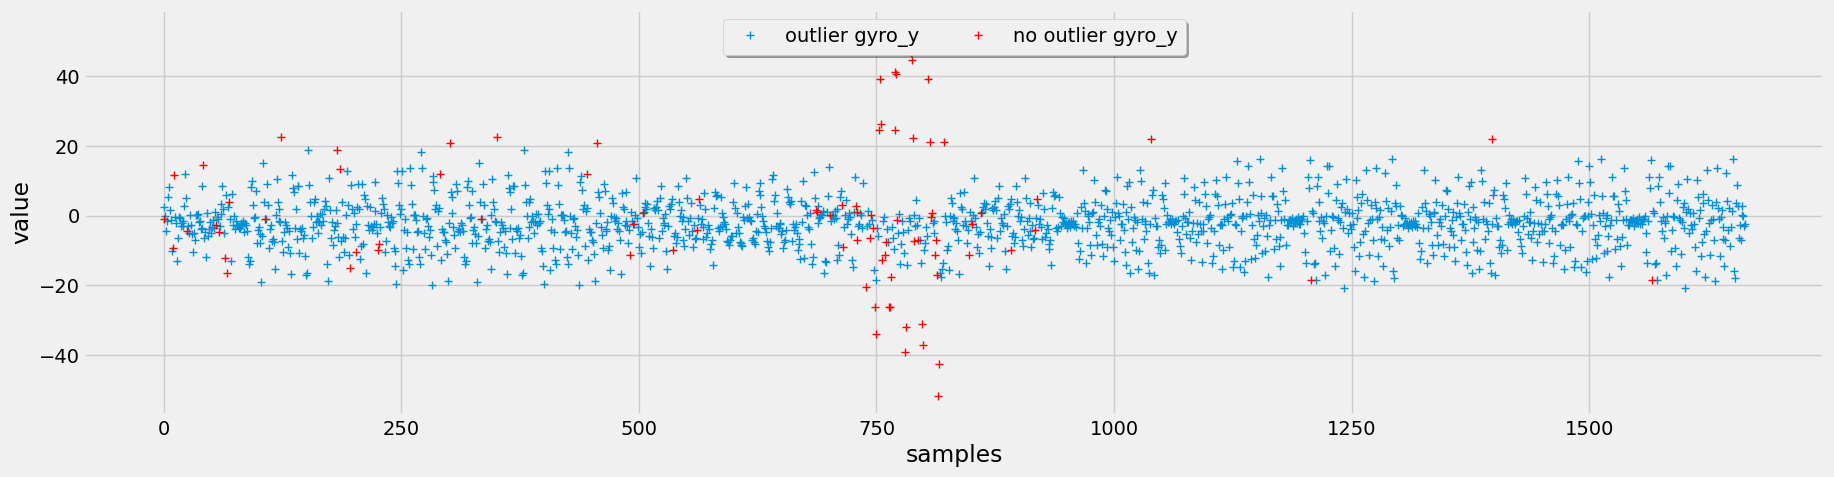

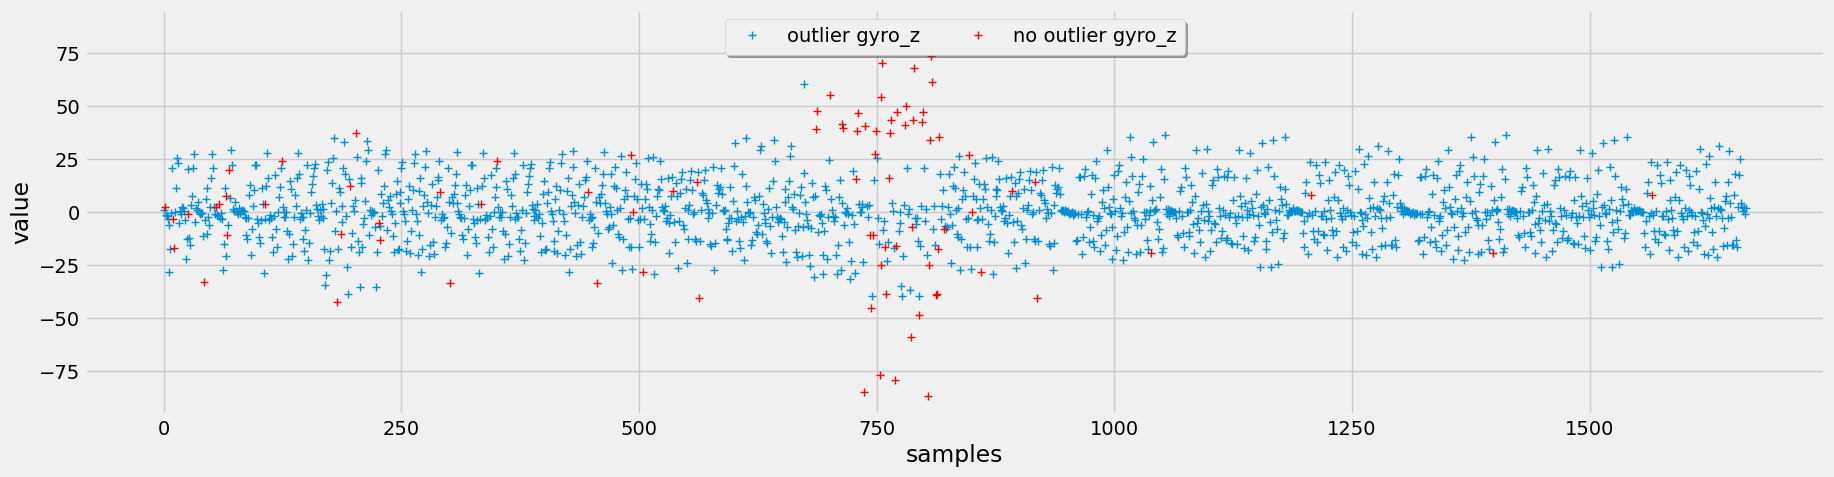

In [63]:
# Usign LOF function
df_loc_label, outliers, X_scores = mark_outliers_lof(df[df["excercise"] == label], col_num, n=20)
# Plot a single column
for col in col_num:
  plot_binary_outliers(df_loc_label, col, "outlier_lof", True)

In [69]:
# --------------------------------------------------------------
# Choose method and deal with outliers
# --------------------------------------------------------------
label = "gyro_y"
# Test on single column
dataset = mark_outliers_chauvenet(df, col = label)
dataset.loc[dataset[f"{label}_outlier"], label] = np.nan
dataset[dataset[f"{label}_outlier"]]

acc_x     acc_y     acc_z    gyro_x  gyro_y  \
epoch (ms)                                                                
2019-01-15 19:31:03.200  0.148000 -1.073333  0.013000  -16.6462     NaN   
2019-01-15 19:31:09.200  0.094000 -0.944667  0.130000   79.5490     NaN   
2019-01-16 19:31:03.200  0.148000 -1.073333  0.013000  -16.6462     NaN   
2019-01-16 19:31:09.200  0.094000 -0.944667  0.130000   79.5490     NaN   
2019-01-18 17:22:29.400  0.831500 -0.070000  0.435500  -24.9880     NaN   
...                           ...       ...       ...       ...     ...   
2019-01-20 17:26:11.600  0.419000  0.175500 -0.176500  171.8048     NaN   
2019-01-20 17:26:11.800  1.155333 -0.807667 -0.160333  -81.4878     NaN   
2019-01-20 17:26:12.000  0.402500 -1.332000  0.548500   14.2074     NaN   
2019-01-20 17:26:12.200  0.334333 -1.023667  0.295667   88.2560     NaN   
2019-01-20 17:26:12.600  0.347000 -0.869333  0.319667  -42.4026     NaN   

                           gyro_z participant excercise intensity  ind  \
epoch (ms)                                                               
2019-01-15 19:31:03.200    6.7442           A      dead    medium   31   
2019-01-15 19:31:09.200  -18.5244           A      dead    medium   31   
2019-01-16 19:31:03.200    6.7442           E      dead    medium   39   
2019-01-16 19:31:09.200  -18.5244           E      dead    medium   39   
2019-01-18 17:22:29.400   49.4270           A      rest   sitting   35   
...                           ...         ...       ...       ...  ...   
2019-01-20 17:26:11.600  267.3416           E      rest  standing   73   
2019-01-20 17:26:11.800  248.3416           E      rest  standing   73   
2019-01-20 17:26:12.000   -5.3048           E      rest  standing   73   
2019-01-20 17:26:12.200  -63.6218           E      rest  standing   73   
2019-01-20 17:26:12.600   47.8538           E      rest  standing   73   

                         gyro_y_outlier  
epoch (ms)                               
2019-01-15 19:31:03.200            True  
2019-01-15 19:31:09.200            True  
2019-01-16 19:31:03.200            True  
2019-01-16 19:31:09.200            True  
2019-01-18 17:22:29.400            True  
...                                 ...  
2019-01-20 17:26:11.600            True  
2019-01-20 17:26:11.800            True  
2019-01-20 17:26:12.000            True  
2019-01-20 17:26:12.200            True  
2019-01-20 17:26:12.600            True  

[124 rows x 11 columns]

In [114]:
# Create a loop
dataset = df.copy()
for col in col_num:
  for label in df.excercise.unique():
    dataset_label = mark_outliers_chauvenet(dataset[dataset["excercise"] == label], col)

    # Set dataset_label values to np.nan
    dataset_label.loc[dataset_label[f"{col}_outlier"], col] = np.nan

    # Update the dataset
    dataset.loc[(dataset["excercise"] == label), col] = dataset_label[col]

In [126]:
# --------------------------------------------------------------
# Export new dataframe
# --------------------------------------------------------------
dataset.info()
dataset.to_pickle("02_data_outlier_removed.pkl")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9005 non-null   float64
 1   acc_y        8998 non-null   float64
 2   acc_z        8999 non-null   float64
 3   gyro_x       8984 non-null   float64
 4   gyro_y       8938 non-null   float64
 5   gyro_z       8945 non-null   float64
 6   participant  9009 non-null   object 
 7   excercise    9009 non-null   object 
 8   intensity    9009 non-null   object 
 9   ind          9009 non-null   int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 1.0+ MB


In [127]:
df_1 = pd.read_pickle("/content/02_data_outlier_removed.pkl")

In [129]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9005 non-null   float64
 1   acc_y        8998 non-null   float64
 2   acc_z        8999 non-null   float64
 3   gyro_x       8984 non-null   float64
 4   gyro_y       8938 non-null   float64
 5   gyro_z       8945 non-null   float64
 6   participant  9009 non-null   object 
 7   excercise    9009 non-null   object 
 8   intensity    9009 non-null   object 
 9   ind          9009 non-null   int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 774.2+ KB
